# NBEATSx Account Balance Forecasting - Next 30 Days

This notebook implements a complete forecasting system to predict account balance for the next 30 days using NBEATSx neural network model with optimized hyperparameters.

## Project Overview

- **Model**: NBEATSx (Neural Basis Expansion Analysis for Time Series Forecasting)
- **Objective**: Predict account balance for the next 30 days
- **Data**: Preprocessed training dataset with engineered features
- **Optimization**: Optuna hyperparameter tuning with 11-hour timeout
- **Database**: SQLite for Optuna study storage
- **Features**: Time-based features, lags, rolling statistics

## Workflow
1. **Data Import** - Load preprocessed dataset
2. **Data Validation** - Verify data quality and completeness
3. **Hyperparameter Tuning** - Optimize model parameters using Optuna
4. **Model Training** - Train final model with best parameters
5. **Forecasting** - Generate 30-day predictions with uncertainty intervals
6. **Evaluation & Analysis** - Analyze results and model performance

## 1. Import Libraries and Setup

Import all required libraries for data processing, modeling, visualization, and hyperparameter optimization.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))




!pip install neuralforecast
!pip install optuna

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/datasets-research/processed_train_dataset.xlsx
/kaggle/input/datasets-research/processed_test_dataset.xlsx
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.0/261.0 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 285.8/285.8 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 81.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 57.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 28.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 26.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.5 MB/s eta 0:00:00

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Time series and forecasting
from neuralforecast import NeuralForecast
from neuralforecast.models import NBEATSx
from neuralforecast.losses.pytorch import DistributionLoss

# Metrics and evaluation
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

# Hyperparameter optimization
import optuna
from optuna.trial import Trial
import sqlite3

# Date and time
from datetime import datetime, timedelta
import json

# Set random seeds for reproducibility
np.random.seed(42)

# Configure matplotlib
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['figure.dpi'] = 100

print("✅ All libraries imported successfully!")
print(f"📅 Current time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"🔧 Optuna version: {optuna.__version__}")
print("🚀 Ready for forecasting!")

✅ All libraries imported successfully!
📅 Current time: 2025-07-28 16:13:53
🔧 Optuna version: 4.4.0
🚀 Ready for forecasting!


## 2. Data Loading and Validation

Load the preprocessed dataset and validate data quality. The dataset should already be preprocessed with features engineered.

In [3]:
# Load the preprocessed dataset
print("📂 Loading preprocessed dataset...")
df = pd.read_excel("/kaggle/input/datasets-research/processed_train_dataset.xlsx")

print(f"✅ Dataset loaded successfully!")
print(f"📊 Dataset shape: {df.shape}")
print(f"📅 Date range: {df['Date'].min()} to {df['Date'].max()}")
print(f"📈 Total days: {len(df)}")

# Display basic info
print("\n📋 Dataset Info:")
print(f"Columns: {list(df.columns)}")
print(f"Data types:\n{df.dtypes}")

# Display first few rows
print("\n🔍 First 5 rows:")
print(df.head())

# Check for any missing values
print(f"\n❌ Missing values:")
missing_values = df.isnull().sum()
for col, missing in missing_values.items():
    if missing > 0:
        print(f"   {col}: {missing} ({missing/len(df)*100:.2f}%)")
    
if missing_values.sum() == 0:
    print("   ✅ No missing values found!")
else:
    print(f"   ⚠️ Total missing values: {missing_values.sum()}")

📂 Loading preprocessed dataset...
✅ Dataset loaded successfully!
📊 Dataset shape: (665, 12)
📅 Date range: 2022-12-27 00:00:00 to 2024-12-03 00:00:00
📈 Total days: 665

📋 Dataset Info:
Columns: ['Date', 'Normalized_Balance', 'dayofweek_sin', 'dayofweek_cos', 'balance_1d_ago', 'balance_7d_ago', 'balance_30d_ago', 'rolling_mean_7d', 'rolling_mean_30d', 'rolling_std_7d', 'rolling_std_30d', 'balance_changed']
Data types:
Date                  datetime64[ns]
Normalized_Balance           float64
dayofweek_sin                float64
dayofweek_cos                float64
balance_1d_ago               float64
balance_7d_ago               float64
balance_30d_ago              float64
rolling_mean_7d              float64
rolling_mean_30d             float64
rolling_std_7d               float64
rolling_std_30d              float64
balance_changed                int64
dtype: object

🔍 First 5 rows:
        Date  Normalized_Balance  dayofweek_sin  dayofweek_cos  \
0 2022-12-27            0.049410       

In [4]:
# Data validation and feature identification
print("🔍 Data Validation and Feature Analysis")
print("="*60)

# Validate essential columns
required_columns = ['Date', 'Normalized_Balance']
missing_required = [col for col in required_columns if col not in df.columns]

if missing_required:
    print(f"❌ Missing required columns: {missing_required}")
    raise ValueError(f"Dataset must contain columns: {required_columns}")
else:
    print("✅ All required columns present")

# Identify feature types
feature_categories = {
    'date_column': 'Date',
    'target_column': 'Normalized_Balance',
    'future_features': [],
    'historical_features': []
}

# Categorize features automatically
for col in df.columns:
    if col in required_columns:
        continue
    elif any(x in col.lower() for x in ['dayofweek_sin', 'dayofweek_cos', 'sin', 'cos']):
        feature_categories['future_features'].append(col)
    elif any(x in col.lower() for x in ['ago', 'lag', 'rolling', 'mean', 'std', 'changed']):
        feature_categories['historical_features'].append(col)

print(f"\n📊 Feature Categories:")
print(f"🎯 Target: {feature_categories['target_column']}")
print(f"🔮 Future features ({len(feature_categories['future_features'])}): {feature_categories['future_features']}")
print(f"📈 Historical features ({len(feature_categories['historical_features'])}): {feature_categories['historical_features']}")

# Validate data quality
print(f"\n🔍 Data Quality Checks:")

# Check date continuity
df_sorted = df.sort_values('Date').reset_index(drop=True)
date_diff = df_sorted['Date'].diff().dt.days
missing_dates = (date_diff > 1).sum()
print(f"📅 Date continuity: {len(df_sorted) - missing_dates - 1}/{len(df_sorted) - 1} consecutive days")

# Check target variable
target_stats = df[feature_categories['target_column']].describe()
print(f"💰 Target variable stats:")
print(f"   Range: {target_stats['min']:.4f} to {target_stats['max']:.4f}")
print(f"   Mean: {target_stats['mean']:.4f}, Std: {target_stats['std']:.4f}")

# Check for outliers (values beyond 3 standard deviations)
target_col = feature_categories['target_column']
mean_val = df[target_col].mean()
std_val = df[target_col].std()
outliers = ((df[target_col] - mean_val).abs() > 3 * std_val).sum()
print(f"⚠️ Potential outliers (>3σ): {outliers} ({outliers/len(df)*100:.2f}%)")

print("\n✅ Data validation completed!")

🔍 Data Validation and Feature Analysis
✅ All required columns present

📊 Feature Categories:
🎯 Target: Normalized_Balance
🔮 Future features (2): ['dayofweek_sin', 'dayofweek_cos']
📈 Historical features (8): ['balance_1d_ago', 'balance_7d_ago', 'balance_30d_ago', 'rolling_mean_7d', 'rolling_mean_30d', 'rolling_std_7d', 'rolling_std_30d', 'balance_changed']

🔍 Data Quality Checks:
📅 Date continuity: 663/664 consecutive days
💰 Target variable stats:
   Range: 0.0000 to 1.0000
   Mean: 0.3045, Std: 0.2437
⚠️ Potential outliers (>3σ): 0 (0.00%)

✅ Data validation completed!


## 3. Hyperparameter Tuning with Optuna

Optimize NBEATSx model hyperparameters using Optuna with SQLite storage and 11-hour timeout.

In [5]:
# Setup Optuna study with SQLite storage
print("🔧 Setting up Optuna hyperparameter optimization")
print("="*60)

# Configuration
HORIZON = 30  # Forecast horizon (days)
TIMEOUT_HOURS = 11  # 11 hours timeout
TIMEOUT_SECONDS = TIMEOUT_HOURS * 3600
STUDY_NAME = "nbeats_balance_forecasting"
DB_URL = f"sqlite:///optuna_study_{STUDY_NAME}.db"

print(f"🎯 Forecast horizon: {HORIZON} days")
print(f"⏰ Timeout: {TIMEOUT_HOURS} hours ({TIMEOUT_SECONDS} seconds)")
print(f"💾 Database: {DB_URL}")

# Create or load existing study
try:
    study = optuna.create_study(
        study_name=STUDY_NAME,
        storage=DB_URL,
        direction='minimize',
        load_if_exists=True
    )
    print(f"✅ Study loaded/created: {len(study.trials)} existing trials")
except Exception as e:
    print(f"⚠️ Creating new study: {e}")
    study = optuna.create_study(
        study_name=STUDY_NAME,
        storage=DB_URL,
        direction='minimize'
    )

# Split data for hyperparameter tuning (use last HORIZON days for validation)
VALIDATION_DAYS = HORIZON  # Use same number of days as forecast horizon
split_idx = len(df) - VALIDATION_DAYS
train_data = df.iloc[:split_idx].copy()
val_data = df.iloc[split_idx:].copy()

print(f"📊 Training data: {len(train_data)} days ({df['Date'].iloc[0]} to {df['Date'].iloc[split_idx-1]})")
print(f"📊 Validation data: {len(val_data)} days ({df['Date'].iloc[split_idx]} to {df['Date'].iloc[-1]})")
print(f"🎯 Validation size matches forecast horizon: {len(val_data)} days")

# Prepare data for NeuralForecast format
def prepare_neural_forecast_data(data, feature_categories):
    """Convert data to NeuralForecast format"""
    nf_data = data.copy()
    nf_data['unique_id'] = 'balance'
    nf_data = nf_data.rename(columns={
        feature_categories['date_column']: 'ds', 
        feature_categories['target_column']: 'y'
    })
    return nf_data

train_nf = prepare_neural_forecast_data(train_data, feature_categories)
val_nf = prepare_neural_forecast_data(val_data, feature_categories)

print("✅ Data prepared for optimization!")

🔧 Setting up Optuna hyperparameter optimization
🎯 Forecast horizon: 30 days
⏰ Timeout: 11 hours (39600 seconds)
💾 Database: sqlite:///optuna_study_nbeats_balance_forecasting.db


[I 2025-07-28 16:13:57,244] A new study created in RDB with name: nbeats_balance_forecasting


✅ Study loaded/created: 0 existing trials
📊 Training data: 635 days (2022-12-27 00:00:00 to 2024-11-03 00:00:00)
📊 Validation data: 30 days (2024-11-04 00:00:00 to 2024-12-03 00:00:00)
🎯 Validation size matches forecast horizon: 30 days
✅ Data prepared for optimization!


In [6]:
# Future features creation function
def create_future_features(last_date, horizon, feature_categories):
    """
    Create future features for forecasting period.
    Only creates features that can be known in advance (like time-based features).
    """
    # Generate future dates
    future_dates = pd.date_range(
        start=last_date + pd.Timedelta(days=1), 
        periods=horizon, 
        freq='D'
    )
    
    # Create future dataframe
    future_df = pd.DataFrame({
        'ds': future_dates,
        'unique_id': 'balance'
    })
    
    # Add time-based features (these can be known in advance)
    future_df['dayofweek_sin'] = np.sin(2 * np.pi * future_df['ds'].dt.dayofweek / 7)
    future_df['dayofweek_cos'] = np.cos(2 * np.pi * future_df['ds'].dt.dayofweek / 7)
    
    # Add any other future features that exist in the dataset
    for feature in feature_categories['future_features']:
        if feature not in future_df.columns:
            if 'sin' in feature.lower():
                # Handle additional sine features
                if 'month' in feature.lower():
                    future_df[feature] = np.sin(2 * np.pi * future_df['ds'].dt.month / 12)
                elif 'dayofyear' in feature.lower():
                    future_df[feature] = np.sin(2 * np.pi * future_df['ds'].dt.dayofyear / 365.25)
                else:
                    future_df[feature] = 0  # Default value
            elif 'cos' in feature.lower():
                # Handle additional cosine features
                if 'month' in feature.lower():
                    future_df[feature] = np.cos(2 * np.pi * future_df['ds'].dt.month / 12)
                elif 'dayofyear' in feature.lower():
                    future_df[feature] = np.cos(2 * np.pi * future_df['ds'].dt.dayofyear / 365.25)
                else:
                    future_df[feature] = 0  # Default value
            else:
                future_df[feature] = 0  # Default for unknown future features
    
    print(f"🔮 Created future features for {horizon} days")
    print(f"📅 Future period: {future_dates[0]} to {future_dates[-1]}")
    
    return future_df

# Test future features creation
last_training_date = train_nf['ds'].max()
test_future_df = create_future_features(last_training_date, 5, feature_categories)
print("\n📋 Sample future features:")
print(test_future_df.head())

🔮 Created future features for 5 days
📅 Future period: 2024-11-04 00:00:00 to 2024-11-08 00:00:00

📋 Sample future features:
          ds unique_id  dayofweek_sin  dayofweek_cos
0 2024-11-04   balance       0.000000       1.000000
1 2024-11-05   balance       0.781831       0.623490
2 2024-11-06   balance       0.974928      -0.222521
3 2024-11-07   balance       0.433884      -0.900969
4 2024-11-08   balance      -0.433884      -0.900969


In [7]:
# Optuna objective function
def objective(trial):
    """
    Optuna objective function for NBEATSx hyperparameter optimization.
    Returns RMSE score to minimize.
    """
    try:
        # Hyperparameter search space
        params = {
            'input_size': trial.suggest_int('input_size', 60, 200),
            'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True),
            'max_steps': trial.suggest_int('max_steps', 500, 2000),
            'batch_size': trial.suggest_int('batch_size', 16, 64),
            'n_harmonics': trial.suggest_int('n_harmonics', 1, 5),
            'n_polynomials': trial.suggest_int('n_polynomials', 1, 5),
            'dropout_prob_theta': trial.suggest_float('dropout_prob_theta', 0.0, 0.3)
            # Removed weight_decay as it's not supported by NBEATSx trainer
        }
        
        # N-blocks for each stack (identity, trend, seasonality)
        n_blocks = [
            trial.suggest_int('n_blocks_identity', 2, 6),
            trial.suggest_int('n_blocks_trend', 2, 6), 
            trial.suggest_int('n_blocks_seasonality', 2, 6)
        ]
        
        # Create NBEATSx model
        model = NBEATSx(
            h=HORIZON,
            input_size=params['input_size'],
            futr_exog_list=feature_categories['future_features'],
            hist_exog_list=feature_categories['historical_features'],
            
            # Architecture parameters
            stack_types=['identity', 'trend', 'seasonality'],
            n_blocks=n_blocks,
            n_harmonics=params['n_harmonics'],
            n_polynomials=params['n_polynomials'],
            
            # Training parameters
            learning_rate=params['learning_rate'],
            max_steps=params['max_steps'],
            batch_size=params['batch_size'],
            dropout_prob_theta=params['dropout_prob_theta'],
            # Removed weight_decay and early_stop_patience_steps as they're not supported
            
            # Other settings
            random_seed=42,
            scaler_type='standard',
            loss=DistributionLoss(distribution='Normal', level=[80, 90, 95])
            # Removed trainer_kwargs as it's not supported by NBEATSx
        )
        
        # Create forecaster
        forecaster = NeuralForecast(models=[model], freq='D')
        
        # Fit model on training data (no early stopping, so no validation needed)
        forecaster.fit(df=train_nf)
        
        # Create future features for validation period
        future_df = create_future_features(
            last_date=train_nf['ds'].max(),
            horizon=len(val_nf),
            feature_categories=feature_categories
        )
        
        # Generate predictions
        forecast_df = forecaster.predict(futr_df=future_df)
        
        # Calculate RMSE
        actual = val_nf['y'].values
        predicted = forecast_df['NBEATSx'].values
        
        # Handle any potential NaN values
        mask = ~(np.isnan(actual) | np.isnan(predicted))
        if mask.sum() == 0:
            return float('inf')
            
        rmse = np.sqrt(mean_squared_error(actual[mask], predicted[mask]))
        
        # Log trial info
        trial_info = {
            'trial_number': trial.number,
            'rmse': rmse,
            'params': params,
            'n_blocks': n_blocks
        }
        
        print(f"Trial {trial.number}: RMSE = {rmse:.6f}")
        
        return rmse
        
    except Exception as e:
        print(f"Trial {trial.number} failed: {str(e)}")
        return float('inf')

print("🎯 Objective function defined!")
print("⚙️ Hyperparameter search space:")
print("   - input_size: 60-200")
print("   - learning_rate: 1e-4 to 1e-2 (log scale)")
print("   - max_steps: 500-2000")
print("   - batch_size: 16-64")
print("   - n_blocks per stack: 2-6 each")
print("   - n_harmonics: 1-5")
print("   - n_polynomials: 1-5")
print("   - dropout_prob_theta: 0.0-0.3")
print("   Note: Early stopping and weight_decay disabled (not supported by NBEATSx)")

🎯 Objective function defined!
⚙️ Hyperparameter search space:
   - input_size: 60-200
   - learning_rate: 1e-4 to 1e-2 (log scale)
   - max_steps: 500-2000
   - batch_size: 16-64
   - n_blocks per stack: 2-6 each
   - n_harmonics: 1-5
   - n_polynomials: 1-5
   - dropout_prob_theta: 0.0-0.3
   Note: Early stopping and weight_decay disabled (not supported by NBEATSx)


In [8]:
# Run hyperparameter optimization
print("🚀 Starting hyperparameter optimization...")
print("="*60)
print(f"⏰ Timeout: {TIMEOUT_HOURS} hours")
print(f"💾 Results will be saved to: {DB_URL}")
print(f"🔄 Existing trials: {len(study.trials)}")

# Record start time
start_time = datetime.now()
print(f"🕐 Start time: {start_time.strftime('%Y-%m-%d %H:%M:%S')}")

# Run optimization with timeout
try:
    study.optimize(
        objective, 
        timeout=TIMEOUT_SECONDS,
        n_jobs=1,  # Single job to avoid conflicts
        show_progress_bar=True
    )
    
    optimization_completed = True
    print("\n✅ Optimization completed successfully!")
    
except KeyboardInterrupt:
    print("\n⚠️ Optimization interrupted by user")
    optimization_completed = False
    
except Exception as e:
    print(f"\n❌ Optimization failed: {e}")
    optimization_completed = False

# Record end time and duration
end_time = datetime.now()
duration = end_time - start_time
print(f"🕐 End time: {end_time.strftime('%Y-%m-%d %H:%M:%S')}")
print(f"⏱️ Duration: {duration}")

# Display results
print("\n" + "="*60)
print("📊 OPTIMIZATION RESULTS")
print("="*60)

if len(study.trials) > 0:
    print(f"🔄 Total trials completed: {len(study.trials)}")
    print(f"🏆 Best RMSE: {study.best_value:.6f}")
    
    # Get best parameters
    best_params = study.best_params.copy()
    
    # Reconstruct n_blocks array
    n_blocks_best = [
        best_params.pop('n_blocks_identity'),
        best_params.pop('n_blocks_trend'),
        best_params.pop('n_blocks_seasonality')
    ]
    best_params['n_blocks'] = n_blocks_best
    
    print(f"\n🎯 Best hyperparameters:")
    for param, value in best_params.items():
        print(f"   {param}: {value}")
    
    # Save best parameters
    with open('best_hyperparameters.json', 'w') as f:
        json.dump(best_params, f, indent=2, default=str)
    print(f"\n💾 Best parameters saved to: best_hyperparameters.json")
    
else:
    print("❌ No trials completed")
    best_params = None

print("="*60)

🚀 Starting hyperparameter optimization...
⏰ Timeout: 11 hours
💾 Results will be saved to: sqlite:///optuna_study_nbeats_balance_forecasting.db
🔄 Existing trials: 0
🕐 Start time: 2025-07-28 16:13:57


   0%|          | 00:00/11:00:00

2025-07-28 16:14:00.107961: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753719240.346341      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753719240.419253      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

🔮 Created future features for 30 days
📅 Future period: 2024-11-04 00:00:00 to 2024-12-03 00:00:00


Predicting: |          | 0/? [00:00<?, ?it/s]

Trial 0: RMSE = 0.276136
[I 2025-07-28 16:33:32,809] Trial 0 finished with value: 0.2761357061637707 and parameters: {'input_size': 115, 'learning_rate': 0.0020357315964295883, 'max_steps': 962, 'batch_size': 34, 'n_harmonics': 5, 'n_polynomials': 5, 'dropout_prob_theta': 0.29622202971125133, 'n_blocks_identity': 2, 'n_blocks_trend': 6, 'n_blocks_seasonality': 3}. Best is trial 0 with value: 0.2761357061637707.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

🔮 Created future features for 30 days
📅 Future period: 2024-11-04 00:00:00 to 2024-12-03 00:00:00


Predicting: |          | 0/? [00:00<?, ?it/s]

Trial 1: RMSE = 0.201621
[I 2025-07-28 16:45:17,947] Trial 1 finished with value: 0.20162067536694872 and parameters: {'input_size': 118, 'learning_rate': 0.0002082475193591474, 'max_steps': 728, 'batch_size': 56, 'n_harmonics': 1, 'n_polynomials': 4, 'dropout_prob_theta': 0.246236442276482, 'n_blocks_identity': 2, 'n_blocks_trend': 2, 'n_blocks_seasonality': 5}. Best is trial 1 with value: 0.20162067536694872.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

🔮 Created future features for 30 days
📅 Future period: 2024-11-04 00:00:00 to 2024-12-03 00:00:00


Predicting: |          | 0/? [00:00<?, ?it/s]

Trial 2: RMSE = 0.161992
[I 2025-07-28 17:33:04,499] Trial 2 finished with value: 0.1619923684182867 and parameters: {'input_size': 179, 'learning_rate': 0.001116962277230821, 'max_steps': 1370, 'batch_size': 52, 'n_harmonics': 4, 'n_polynomials': 1, 'dropout_prob_theta': 0.2901186513429097, 'n_blocks_identity': 6, 'n_blocks_trend': 5, 'n_blocks_seasonality': 5}. Best is trial 2 with value: 0.1619923684182867.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

🔮 Created future features for 30 days
📅 Future period: 2024-11-04 00:00:00 to 2024-12-03 00:00:00


Predicting: |          | 0/? [00:00<?, ?it/s]

Trial 3: RMSE = 581009.113696
[I 2025-07-28 18:25:04,151] Trial 3 finished with value: 581009.1136959846 and parameters: {'input_size': 180, 'learning_rate': 0.0024664417917760893, 'max_steps': 1572, 'batch_size': 33, 'n_harmonics': 5, 'n_polynomials': 4, 'dropout_prob_theta': 0.28116131564492514, 'n_blocks_identity': 6, 'n_blocks_trend': 6, 'n_blocks_seasonality': 3}. Best is trial 2 with value: 0.1619923684182867.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

🔮 Created future features for 30 days
📅 Future period: 2024-11-04 00:00:00 to 2024-12-03 00:00:00


Predicting: |          | 0/? [00:00<?, ?it/s]

Trial 4: RMSE = 0.234180
[I 2025-07-28 19:14:47,613] Trial 4 finished with value: 0.23417975396363097 and parameters: {'input_size': 187, 'learning_rate': 0.0006768726796725176, 'max_steps': 1496, 'batch_size': 54, 'n_harmonics': 4, 'n_polynomials': 3, 'dropout_prob_theta': 0.04443667062313983, 'n_blocks_identity': 3, 'n_blocks_trend': 6, 'n_blocks_seasonality': 6}. Best is trial 2 with value: 0.1619923684182867.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

🔮 Created future features for 30 days
📅 Future period: 2024-11-04 00:00:00 to 2024-12-03 00:00:00


Predicting: |          | 0/? [00:00<?, ?it/s]

Trial 5: RMSE = 777137.026903
[I 2025-07-28 20:14:06,752] Trial 5 finished with value: 777137.0269025394 and parameters: {'input_size': 200, 'learning_rate': 0.006624928995096076, 'max_steps': 1572, 'batch_size': 58, 'n_harmonics': 5, 'n_polynomials': 5, 'dropout_prob_theta': 0.021653381656759164, 'n_blocks_identity': 5, 'n_blocks_trend': 6, 'n_blocks_seasonality': 5}. Best is trial 2 with value: 0.1619923684182867.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

🔮 Created future features for 30 days
📅 Future period: 2024-11-04 00:00:00 to 2024-12-03 00:00:00


Predicting: |          | 0/? [00:00<?, ?it/s]

Trial 6: RMSE = 0.089979
[I 2025-07-28 20:37:38,533] Trial 6 finished with value: 0.08997911132734546 and parameters: {'input_size': 198, 'learning_rate': 0.004440702529686719, 'max_steps': 1121, 'batch_size': 56, 'n_harmonics': 1, 'n_polynomials': 2, 'dropout_prob_theta': 0.04106733287553536, 'n_blocks_identity': 5, 'n_blocks_trend': 2, 'n_blocks_seasonality': 2}. Best is trial 6 with value: 0.08997911132734546.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

🔮 Created future features for 30 days
📅 Future period: 2024-11-04 00:00:00 to 2024-12-03 00:00:00


Predicting: |          | 0/? [00:00<?, ?it/s]

Trial 7: RMSE = 32088477883.256699
[I 2025-07-28 21:23:32,942] Trial 7 finished with value: 32088477883.2567 and parameters: {'input_size': 100, 'learning_rate': 0.0041714469083440715, 'max_steps': 1807, 'batch_size': 49, 'n_harmonics': 1, 'n_polynomials': 2, 'dropout_prob_theta': 0.018814200151194605, 'n_blocks_identity': 4, 'n_blocks_trend': 6, 'n_blocks_seasonality': 5}. Best is trial 6 with value: 0.08997911132734546.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

🔮 Created future features for 30 days
📅 Future period: 2024-11-04 00:00:00 to 2024-12-03 00:00:00


Predicting: |          | 0/? [00:00<?, ?it/s]

Trial 8: RMSE = 0.207868
[I 2025-07-28 21:41:27,587] Trial 8 finished with value: 0.20786774029944702 and parameters: {'input_size': 120, 'learning_rate': 0.00015390931079709773, 'max_steps': 601, 'batch_size': 63, 'n_harmonics': 2, 'n_polynomials': 2, 'dropout_prob_theta': 0.03162689855044204, 'n_blocks_identity': 5, 'n_blocks_trend': 5, 'n_blocks_seasonality': 6}. Best is trial 6 with value: 0.08997911132734546.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

🔮 Created future features for 30 days
📅 Future period: 2024-11-04 00:00:00 to 2024-12-03 00:00:00


Predicting: |          | 0/? [00:00<?, ?it/s]

Trial 9: RMSE = 0.217329
[I 2025-07-28 22:06:28,123] Trial 9 finished with value: 0.21732893468561904 and parameters: {'input_size': 83, 'learning_rate': 0.0011800828110965261, 'max_steps': 1197, 'batch_size': 45, 'n_harmonics': 2, 'n_polynomials': 2, 'dropout_prob_theta': 0.12480716099056247, 'n_blocks_identity': 5, 'n_blocks_trend': 6, 'n_blocks_seasonality': 2}. Best is trial 6 with value: 0.08997911132734546.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

🔮 Created future features for 30 days
📅 Future period: 2024-11-04 00:00:00 to 2024-12-03 00:00:00


Predicting: |          | 0/? [00:00<?, ?it/s]

Trial 10: RMSE = 3002412.659945
[I 2025-07-28 22:24:36,320] Trial 10 finished with value: 3002412.659945121 and parameters: {'input_size': 153, 'learning_rate': 0.009569952369337085, 'max_steps': 1088, 'batch_size': 19, 'n_harmonics': 2, 'n_polynomials': 1, 'dropout_prob_theta': 0.11799942468471702, 'n_blocks_identity': 4, 'n_blocks_trend': 2, 'n_blocks_seasonality': 2}. Best is trial 6 with value: 0.08997911132734546.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

🔮 Created future features for 30 days
📅 Future period: 2024-11-04 00:00:00 to 2024-12-03 00:00:00


Predicting: |          | 0/? [00:00<?, ?it/s]

Trial 11: RMSE = 0.207429
[I 2025-07-28 23:04:17,041] Trial 11 finished with value: 0.20742920802056777 and parameters: {'input_size': 158, 'learning_rate': 0.0006690297040347632, 'max_steps': 1380, 'batch_size': 42, 'n_harmonics': 3, 'n_polynomials': 1, 'dropout_prob_theta': 0.18841978101616091, 'n_blocks_identity': 6, 'n_blocks_trend': 4, 'n_blocks_seasonality': 4}. Best is trial 6 with value: 0.08997911132734546.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

🔮 Created future features for 30 days
📅 Future period: 2024-11-04 00:00:00 to 2024-12-03 00:00:00


Predicting: |          | 0/? [00:00<?, ?it/s]

Trial 12: RMSE = 0.273233
[I 2025-07-28 23:29:38,757] Trial 12 finished with value: 0.2732333106465697 and parameters: {'input_size': 163, 'learning_rate': 0.0003117491690034436, 'max_steps': 868, 'batch_size': 63, 'n_harmonics': 4, 'n_polynomials': 1, 'dropout_prob_theta': 0.19002247403774533, 'n_blocks_identity': 6, 'n_blocks_trend': 4, 'n_blocks_seasonality': 4}. Best is trial 6 with value: 0.08997911132734546.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

🔮 Created future features for 30 days
📅 Future period: 2024-11-04 00:00:00 to 2024-12-03 00:00:00


Predicting: |          | 0/? [00:00<?, ?it/s]

Trial 13: RMSE = 348.793476
[I 2025-07-29 00:09:19,527] Trial 13 finished with value: 348.79347640842155 and parameters: {'input_size': 140, 'learning_rate': 0.0026693043982680704, 'max_steps': 1841, 'batch_size': 50, 'n_harmonics': 3, 'n_polynomials': 2, 'dropout_prob_theta': 0.08528970261299637, 'n_blocks_identity': 5, 'n_blocks_trend': 3, 'n_blocks_seasonality': 3}. Best is trial 6 with value: 0.08997911132734546.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

🔮 Created future features for 30 days
📅 Future period: 2024-11-04 00:00:00 to 2024-12-03 00:00:00


Predicting: |          | 0/? [00:00<?, ?it/s]

Trial 14: RMSE = 0.245604
[I 2025-07-29 00:37:35,490] Trial 14 finished with value: 0.24560447275939076 and parameters: {'input_size': 60, 'learning_rate': 0.0012246948227033574, 'max_steps': 1322, 'batch_size': 34, 'n_harmonics': 4, 'n_polynomials': 3, 'dropout_prob_theta': 0.19396373234152114, 'n_blocks_identity': 6, 'n_blocks_trend': 3, 'n_blocks_seasonality': 5}. Best is trial 6 with value: 0.08997911132734546.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

🔮 Created future features for 30 days
📅 Future period: 2024-11-04 00:00:00 to 2024-12-03 00:00:00


Predicting: |          | 0/? [00:00<?, ?it/s]

Trial 15: RMSE = 0.234276
[I 2025-07-29 01:10:23,407] Trial 15 finished with value: 0.2342756290267907 and parameters: {'input_size': 200, 'learning_rate': 0.0004001580317731217, 'max_steps': 1105, 'batch_size': 48, 'n_harmonics': 3, 'n_polynomials': 1, 'dropout_prob_theta': 0.07349547703668091, 'n_blocks_identity': 5, 'n_blocks_trend': 5, 'n_blocks_seasonality': 2}. Best is trial 6 with value: 0.08997911132734546.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

🔮 Created future features for 30 days
📅 Future period: 2024-11-04 00:00:00 to 2024-12-03 00:00:00


Predicting: |          | 0/? [00:00<?, ?it/s]

Trial 16: RMSE = 22252.588235
[I 2025-07-29 01:34:14,754] Trial 16 finished with value: 22252.588235203977 and parameters: {'input_size': 176, 'learning_rate': 0.0046071767862817855, 'max_steps': 921, 'batch_size': 16, 'n_harmonics': 1, 'n_polynomials': 2, 'dropout_prob_theta': 0.23547072374553124, 'n_blocks_identity': 4, 'n_blocks_trend': 3, 'n_blocks_seasonality': 4}. Best is trial 6 with value: 0.08997911132734546.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

🔮 Created future features for 30 days
📅 Future period: 2024-11-04 00:00:00 to 2024-12-03 00:00:00


Predicting: |          | 0/? [00:00<?, ?it/s]

Trial 17: RMSE = 0.286906
[I 2025-07-29 02:14:54,341] Trial 17 finished with value: 0.28690575747043545 and parameters: {'input_size': 144, 'learning_rate': 0.00010185444822020241, 'max_steps': 1730, 'batch_size': 57, 'n_harmonics': 4, 'n_polynomials': 1, 'dropout_prob_theta': 0.15626672921929413, 'n_blocks_identity': 3, 'n_blocks_trend': 5, 'n_blocks_seasonality': 3}. Best is trial 6 with value: 0.08997911132734546.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

🔮 Created future features for 30 days
📅 Future period: 2024-11-04 00:00:00 to 2024-12-03 00:00:00


Predicting: |          | 0/? [00:00<?, ?it/s]

Trial 18: RMSE = 2512.008632
[I 2025-07-29 03:29:22,731] Trial 18 finished with value: 2512.008631941241 and parameters: {'input_size': 176, 'learning_rate': 0.0019020888432650697, 'max_steps': 1980, 'batch_size': 41, 'n_harmonics': 2, 'n_polynomials': 3, 'dropout_prob_theta': 0.0706522408030488, 'n_blocks_identity': 6, 'n_blocks_trend': 4, 'n_blocks_seasonality': 6}. Best is trial 6 with value: 0.08997911132734546.

✅ Optimization completed successfully!
🕐 End time: 2025-07-29 03:29:22
⏱️ Duration: 11:15:25.228024

📊 OPTIMIZATION RESULTS
🔄 Total trials completed: 19
🏆 Best RMSE: 0.089979

🎯 Best hyperparameters:
   input_size: 198
   learning_rate: 0.004440702529686719
   max_steps: 1121
   batch_size: 56
   n_harmonics: 1
   n_polynomials: 2
   dropout_prob_theta: 0.04106733287553536
   n_blocks: [5, 2, 2]

💾 Best parameters saved to: best_hyperparameters.json


📈 OPTIMIZATION ANALYSIS
✅ Completed trials: 19
❌ Failed trials: 0
📊 Success rate: 100.0%

📊 RMSE Statistics:
   Best (min): 0.089979
   Worst (max): 32088477883.256699
   Mean: 1689098082.004428
   Std: 7361545839.091290
   Median: 0.273233


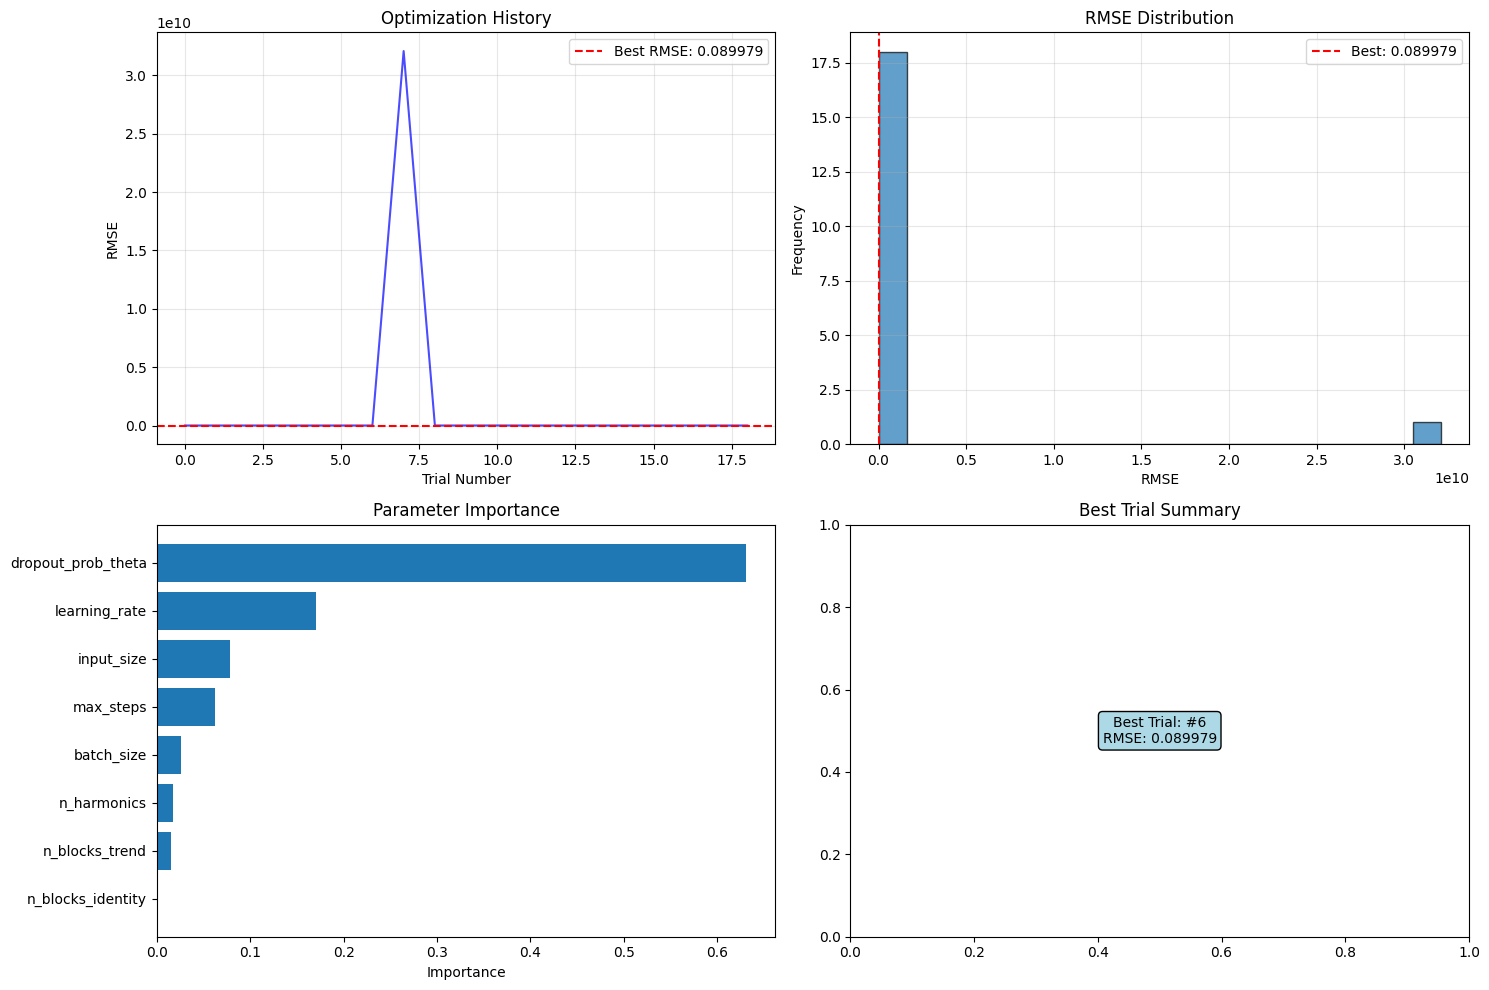


💾 Optimization report saved to: optimization_report.json


In [9]:
# Analyze optimization results
if len(study.trials) > 0:
    print("📈 OPTIMIZATION ANALYSIS")
    print("="*60)
    
    # Create trials dataframe for analysis
    trials_df = study.trials_dataframe()
    completed_trials = trials_df[trials_df['state'] == 'COMPLETE']
    
    if len(completed_trials) > 0:
        print(f"✅ Completed trials: {len(completed_trials)}")
        print(f"❌ Failed trials: {len(trials_df) - len(completed_trials)}")
        print(f"📊 Success rate: {len(completed_trials)/len(trials_df)*100:.1f}%")
        
        # Statistics
        rmse_stats = completed_trials['value'].describe()
        print(f"\n📊 RMSE Statistics:")
        print(f"   Best (min): {rmse_stats['min']:.6f}")
        print(f"   Worst (max): {rmse_stats['max']:.6f}")
        print(f"   Mean: {rmse_stats['mean']:.6f}")
        print(f"   Std: {rmse_stats['std']:.6f}")
        print(f"   Median: {rmse_stats['50%']:.6f}")
        
        # Plot optimization history
        plt.figure(figsize=(15, 10))
        
        # Plot 1: Optimization history
        plt.subplot(2, 2, 1)
        plt.plot(completed_trials['number'], completed_trials['value'], 'b-', alpha=0.7)
        plt.axhline(y=study.best_value, color='r', linestyle='--', label=f'Best RMSE: {study.best_value:.6f}')
        plt.xlabel('Trial Number')
        plt.ylabel('RMSE')
        plt.title('Optimization History')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Plot 2: RMSE distribution
        plt.subplot(2, 2, 2)
        plt.hist(completed_trials['value'], bins=20, alpha=0.7, edgecolor='black')
        plt.axvline(x=study.best_value, color='r', linestyle='--', label=f'Best: {study.best_value:.6f}')
        plt.xlabel('RMSE')
        plt.ylabel('Frequency')
        plt.title('RMSE Distribution')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Plot 3: Parameter importance (if enough trials)
        if len(completed_trials) >= 10:
            plt.subplot(2, 2, 3)
            try:
                importance = optuna.importance.get_param_importances(study)
                params = list(importance.keys())[:8]  # Top 8 parameters
                values = [importance[p] for p in params]
                
                plt.barh(params, values)
                plt.xlabel('Importance')
                plt.title('Parameter Importance')
                plt.gca().invert_yaxis()
            except:
                plt.text(0.5, 0.5, 'Parameter importance\nnot available', 
                        ha='center', va='center', transform=plt.gca().transAxes)
                plt.title('Parameter Importance')
        
        # Plot 4: Learning curve of best trial
        plt.subplot(2, 2, 4)
        # This would show learning curve if we had access to training history
        plt.text(0.5, 0.5, f'Best Trial: #{study.best_trial.number}\nRMSE: {study.best_value:.6f}', 
                ha='center', va='center', transform=plt.gca().transAxes,
                bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue"))
        plt.title('Best Trial Summary')
        
        plt.tight_layout()
        plt.show()
        
        # Save optimization report
        optimization_report = {
            'study_name': STUDY_NAME,
            'total_trials': len(study.trials),
            'completed_trials': len(completed_trials),
            'best_rmse': study.best_value,
            'best_params': best_params,
            'optimization_duration': str(duration),
            'rmse_statistics': rmse_stats.to_dict()
        }
        
        with open('optimization_report.json', 'w') as f:
            json.dump(optimization_report, f, indent=2, default=str)
        
        print(f"\n💾 Optimization report saved to: optimization_report.json")
    else:
        print("❌ No completed trials to analyze")
else:
    print("❌ No trials to analyze")
    best_params = None

## 4. Final Model Training

Train the final NBEATSx model using the best hyperparameters found during optimization, using the entire dataset.

In [10]:
# Train final model with best parameters
print("🚀 Training Final Model")
print("="*60)

# Ensure we have best parameters
if best_params is None:
    print("⚠️ No optimized parameters found, using default parameters")
    best_params = {
        'input_size': 120,
        'learning_rate': 0.001,
        'max_steps': 1000,
        'batch_size': 32,
        'n_blocks': [3, 3, 3],
        'n_harmonics': 2,
        'n_polynomials': 2,
        'dropout_prob_theta': 0.1
        # Removed weight_decay and early_stop_patience_steps as they're not supported
    }

print(f"🎯 Using parameters:")
for param, value in best_params.items():
    print(f"   {param}: {value}")

# Prepare full dataset for training
full_nf_data = prepare_neural_forecast_data(df, feature_categories)
print(f"\n📊 Full training dataset: {len(full_nf_data)} days")
print(f"📅 Training period: {full_nf_data['ds'].min()} to {full_nf_data['ds'].max()}")

# Create final model with best parameters
final_model = NBEATSx(
    h=HORIZON,
    input_size=best_params['input_size'],
    futr_exog_list=feature_categories['future_features'],
    hist_exog_list=feature_categories['historical_features'],
    
    # Architecture parameters
    stack_types=['identity', 'trend', 'seasonality'],
    n_blocks=best_params['n_blocks'],
    n_harmonics=best_params['n_harmonics'],
    n_polynomials=best_params['n_polynomials'],
    
    # Training parameters
    learning_rate=best_params['learning_rate'],
    max_steps=best_params['max_steps'],
    batch_size=best_params['batch_size'],
    dropout_prob_theta=best_params.get('dropout_prob_theta', 0.0),
    # Removed weight_decay and early_stop_patience_steps as they're not supported
    
    # Other settings
    random_seed=42,
    scaler_type='standard',
    loss=DistributionLoss(distribution='Normal', level=[80, 90, 95])
    # Removed trainer_kwargs as it's not supported by NBEATSx
)

# Create final forecaster
final_forecaster = NeuralForecast(models=[final_model], freq='D')

# Train the final model
print(f"\n🎓 Training final model...")
training_start = datetime.now()

try:
    # Train final model without early stopping to avoid validation requirements
    final_forecaster.fit(df=full_nf_data)
    training_success = True
    print("✅ Final model training completed successfully!")
    
except Exception as e:
    training_success = False
    print(f"❌ Final model training failed: {e}")

training_end = datetime.now()
training_duration = training_end - training_start
print(f"⏱️ Training duration: {training_duration}")

if training_success:
    print("\n🎉 Final model ready for forecasting!")

🚀 Training Final Model
🎯 Using parameters:
   input_size: 198
   learning_rate: 0.004440702529686719
   max_steps: 1121
   batch_size: 56
   n_harmonics: 1
   n_polynomials: 2
   dropout_prob_theta: 0.04106733287553536
   n_blocks: [5, 2, 2]

📊 Full training dataset: 665 days
📅 Training period: 2022-12-27 00:00:00 to 2024-12-03 00:00:00

🎓 Training final model...


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

✅ Final model training completed successfully!
⏱️ Training duration: 0:25:33.932745

🎉 Final model ready for forecasting!


## 5. 30-Day Balance Forecasting

Generate predictions for the next 30 days with uncertainty intervals and confidence levels.

In [11]:
# Generate 30-day forecast
if training_success:
    print("🔮 Generating 30-Day Balance Forecast")
    print("="*60)
    
    # Create future features for the next 30 days
    last_date = full_nf_data['ds'].max()
    future_features_df = create_future_features(
        last_date=last_date,
        horizon=HORIZON,
        feature_categories=feature_categories
    )
    
    print(f"📅 Forecast period: {future_features_df['ds'].min()} to {future_features_df['ds'].max()}")
    
    # Generate forecast with uncertainty intervals
    forecast_start = datetime.now()
    
    try:
        forecast_df = final_forecaster.predict(futr_df=future_features_df)
        forecasting_success = True
        print("✅ Forecast generated successfully!")
        
    except Exception as e:
        forecasting_success = False
        print(f"❌ Forecasting failed: {e}")
        forecast_df = None
    
    forecast_end = datetime.now()
    forecast_duration = forecast_end - forecast_start
    print(f"⏱️ Forecasting duration: {forecast_duration}")
    
    if forecasting_success and forecast_df is not None:
        # Process forecast results
        forecast_df['Date'] = future_features_df['ds']
        forecast_df = forecast_df.reset_index(drop=True)
        
        # Extract predictions and confidence intervals
        point_forecast = forecast_df['NBEATSx'].values
        
        # Extract confidence intervals if available
        ci_columns = [col for col in forecast_df.columns if 'NBEATSx' in col and any(level in col for level in ['80', '90', '95'])]
        
        print(f"\n📊 Forecast Summary:")
        print(f"   Horizon: {HORIZON} days")
        print(f"   Point forecasts: {len(point_forecast)} values")
        print(f"   Confidence intervals: {len(ci_columns)} levels")
        print(f"   Available intervals: {[col.split('-')[-1] for col in ci_columns if 'hi' in col]}")
        
        # Create comprehensive forecast dataframe
        forecast_summary = pd.DataFrame({
            'Date': future_features_df['ds'],
            'Day': range(1, HORIZON + 1),
            'Predicted_Balance': point_forecast
        })
        
        # Add confidence intervals
        for col in ci_columns:
            if 'lo' in col:
                level = col.split('-')[-1]
                forecast_summary[f'Lower_CI_{level}'] = forecast_df[col]
            elif 'hi' in col:
                level = col.split('-')[-1]
                forecast_summary[f'Upper_CI_{level}'] = forecast_df[col]
        
        # Add trend information
        forecast_summary['Daily_Change'] = forecast_summary['Predicted_Balance'].diff()
        forecast_summary['Cumulative_Change'] = forecast_summary['Predicted_Balance'] - forecast_summary['Predicted_Balance'].iloc[0]
        forecast_summary['Weekly_Change'] = forecast_summary['Predicted_Balance'].diff(7)
        
        print(f"\n📈 Forecast Statistics:")
        print(f"   Starting balance: {point_forecast[0]:.4f}")
        print(f"   Ending balance: {point_forecast[-1]:.4f}")
        print(f"   Total change: {point_forecast[-1] - point_forecast[0]:.4f}")
        print(f"   Average daily change: {forecast_summary['Daily_Change'].mean():.4f}")
        print(f"   Max daily change: {forecast_summary['Daily_Change'].max():.4f}")
        print(f"   Min daily change: {forecast_summary['Daily_Change'].min():.4f}")
        
        # Display first few predictions
        print(f"\n🔍 First 10 predictions:")
        print(forecast_summary[['Date', 'Day', 'Predicted_Balance', 'Daily_Change']].head(10).to_string(index=False))
        
        # Save forecast results
        forecast_summary.to_csv('30_day_forecast.csv', index=False)
        forecast_summary.to_excel('30_day_forecast.xlsx', index=False)
        print(f"\n💾 Forecast saved to:")
        print(f"   - 30_day_forecast.csv")
        print(f"   - 30_day_forecast.xlsx")
        
    else:
        print("❌ Cannot proceed with analysis - forecasting failed")
        forecast_summary = None

else:
    print("❌ Cannot generate forecast - final model training failed")
    forecast_summary = None

🔮 Generating 30-Day Balance Forecast
🔮 Created future features for 30 days
📅 Future period: 2024-12-04 00:00:00 to 2025-01-02 00:00:00
📅 Forecast period: 2024-12-04 00:00:00 to 2025-01-02 00:00:00


Predicting: |          | 0/? [00:00<?, ?it/s]

✅ Forecast generated successfully!
⏱️ Forecasting duration: 0:00:00.169977

📊 Forecast Summary:
   Horizon: 30 days
   Point forecasts: 30 values
   Confidence intervals: 6 levels
   Available intervals: ['80', '90', '95']

📈 Forecast Statistics:
   Starting balance: 0.6961
   Ending balance: 0.7090
   Total change: 0.0129
   Average daily change: 0.0004
   Max daily change: 0.0927
   Min daily change: -0.0526

🔍 First 10 predictions:
      Date  Day  Predicted_Balance  Daily_Change
2024-12-04    1           0.696085           NaN
2024-12-05    2           0.705094      0.009010
2024-12-06    3           0.727588      0.022494
2024-12-07    4           0.717747     -0.009841
2024-12-08    5           0.722344      0.004597
2024-12-09    6           0.707412     -0.014933
2024-12-10    7           0.671358     -0.036054
2024-12-11    8           0.658340     -0.013018
2024-12-12    9           0.626788     -0.031552
2024-12-13   10           0.602682     -0.024106

💾 Forecast saved to:


📊 Creating Forecast Visualizations


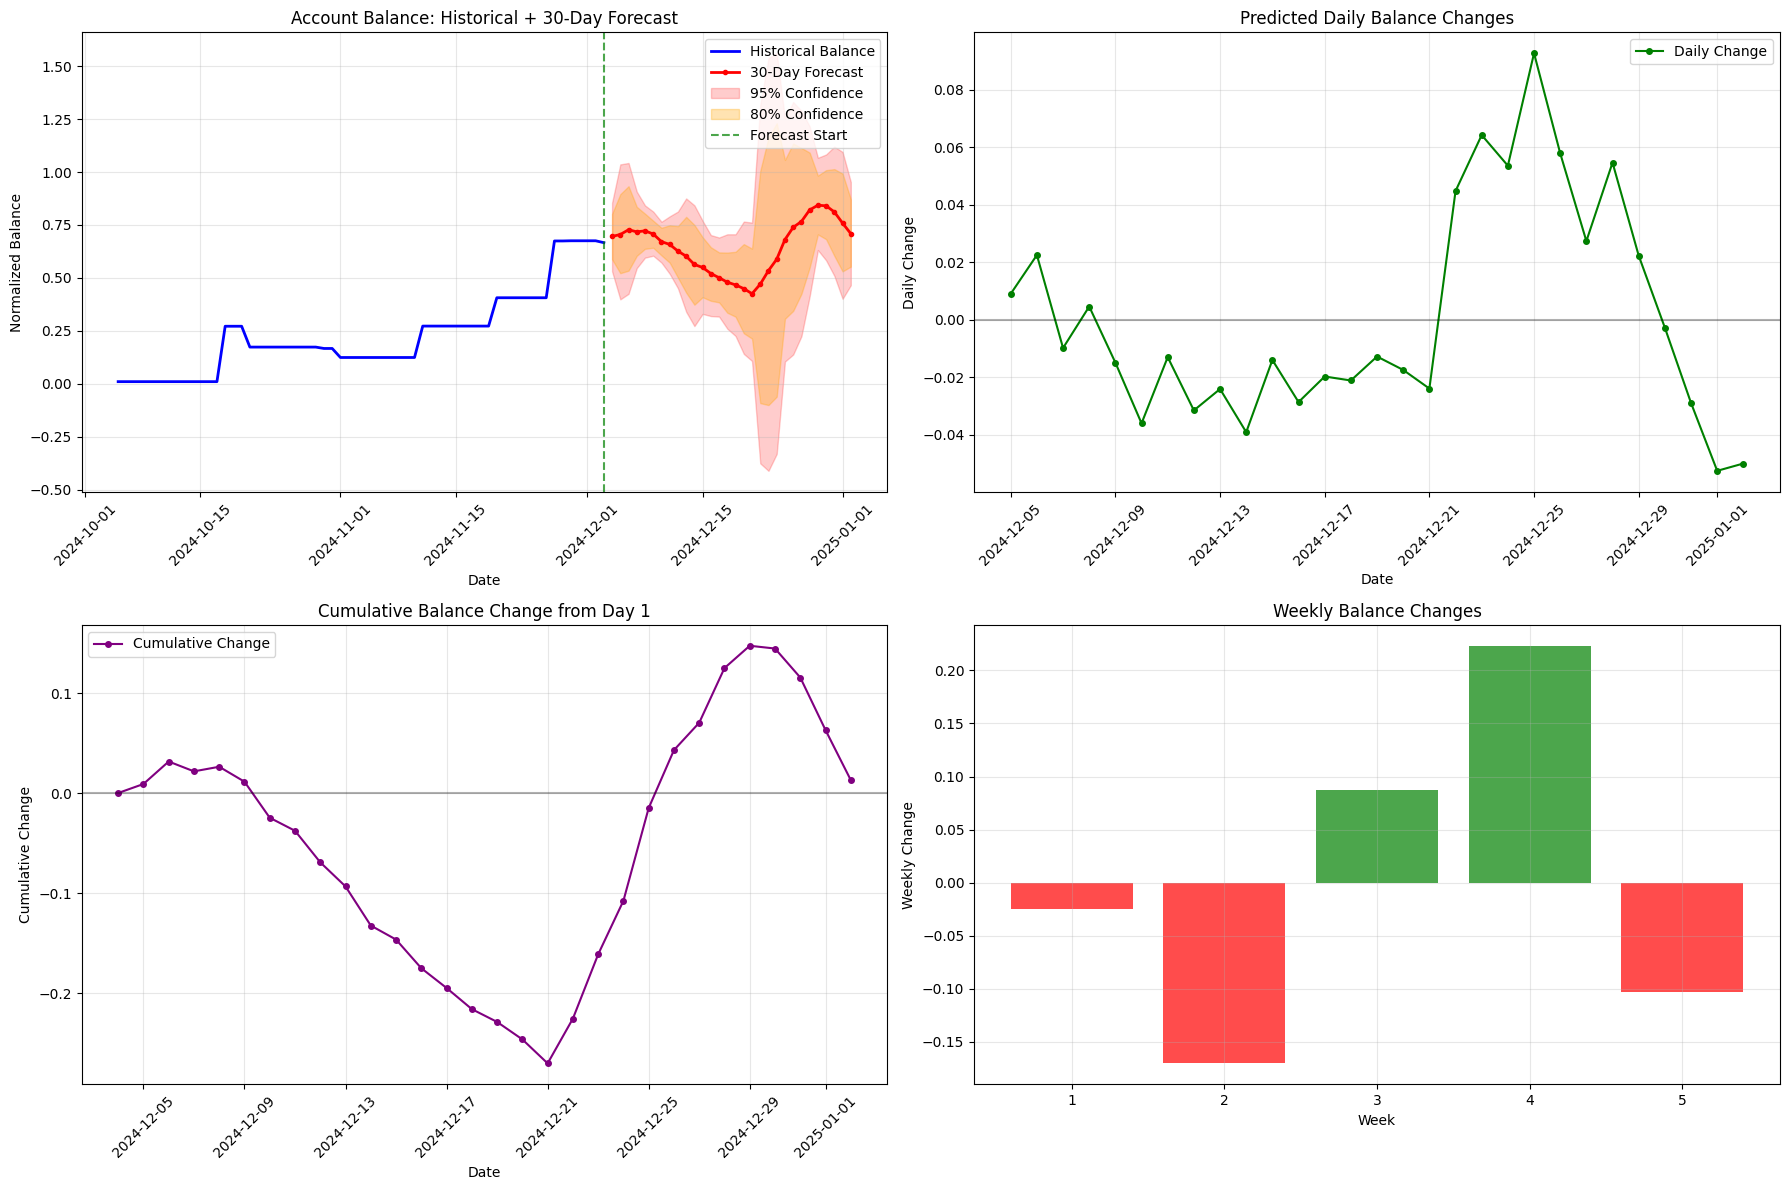


📊 Weekly Forecast Summary:
 Week  Avg_Balance  Min_Balance  Max_Balance  Weekly_Change
    1       0.7068       0.6714       0.7276        -0.0247
    2       0.5747       0.5011       0.6583        -0.1702
    3       0.4881       0.4258       0.5884         0.0872
    4       0.7861       0.6811       0.8433         0.2232
    5       0.7340       0.7090       0.7590        -0.1026

💾 Visualization saved to: 30_day_forecast_visualization.png

⚠️ RISK ANALYSIS:
   📈 Daily volatility (std): 0.0377
   📉 Largest predicted decline: -0.0526
   📈 Largest predicted increase: 0.0927
   📈 Overall 30-day trend: INCREASING
   💰 Expected total change: 0.0129
   ⚠️ Weeks with declining balance: 3/4


In [12]:
# Visualize forecast results
if forecasting_success and forecast_summary is not None:
    print("📊 Creating Forecast Visualizations")
    print("="*60)
    
    # Create comprehensive visualization
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))
    
    # Plot 1: Historical + Forecast
    ax1 = axes[0, 0]
    
    # Show last 60 days of historical data for context
    hist_context = full_nf_data.tail(60)
    ax1.plot(hist_context['ds'], hist_context['y'], 'b-', label='Historical Balance', linewidth=2)
    ax1.plot(forecast_summary['Date'], forecast_summary['Predicted_Balance'], 'r-', 
             label='30-Day Forecast', linewidth=2, marker='o', markersize=3)
    
    # Add confidence intervals if available
    if 'Lower_CI_95' in forecast_summary.columns:
        ax1.fill_between(forecast_summary['Date'], 
                        forecast_summary['Lower_CI_95'], 
                        forecast_summary['Upper_CI_95'],
                        alpha=0.2, color='red', label='95% Confidence')
    
    if 'Lower_CI_80' in forecast_summary.columns:
        ax1.fill_between(forecast_summary['Date'], 
                        forecast_summary['Lower_CI_80'], 
                        forecast_summary['Upper_CI_80'],
                        alpha=0.3, color='orange', label='80% Confidence')
    
    ax1.axvline(x=last_date, color='green', linestyle='--', alpha=0.7, label='Forecast Start')
    ax1.set_title('Account Balance: Historical + 30-Day Forecast')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Normalized Balance')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.tick_params(axis='x', rotation=45)
    
    # Plot 2: Daily Changes
    ax2 = axes[0, 1]
    ax2.plot(forecast_summary['Date'], forecast_summary['Daily_Change'], 'g-', 
             marker='o', markersize=4, label='Daily Change')
    ax2.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    ax2.set_title('Predicted Daily Balance Changes')
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Daily Change')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.tick_params(axis='x', rotation=45)
    
    # Plot 3: Cumulative Change
    ax3 = axes[1, 0]
    ax3.plot(forecast_summary['Date'], forecast_summary['Cumulative_Change'], 'purple', 
             marker='o', markersize=4, label='Cumulative Change')
    ax3.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    ax3.set_title('Cumulative Balance Change from Day 1')
    ax3.set_xlabel('Date')
    ax3.set_ylabel('Cumulative Change')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    ax3.tick_params(axis='x', rotation=45)
    
    # Plot 4: Weekly Analysis
    ax4 = axes[1, 1]
    
    # Group by week for weekly analysis
    forecast_summary['Week'] = ((forecast_summary['Day'] - 1) // 7) + 1
    weekly_summary = forecast_summary.groupby('Week').agg({
        'Predicted_Balance': ['mean', 'min', 'max'],
        'Daily_Change': 'sum'
    }).round(4)
    
    weekly_summary.columns = ['Avg_Balance', 'Min_Balance', 'Max_Balance', 'Weekly_Change']
    weekly_summary = weekly_summary.reset_index()
    
    ax4.bar(weekly_summary['Week'], weekly_summary['Weekly_Change'], 
            alpha=0.7, color=['green' if x >= 0 else 'red' for x in weekly_summary['Weekly_Change']])
    ax4.set_title('Weekly Balance Changes')
    ax4.set_xlabel('Week')
    ax4.set_ylabel('Weekly Change')
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print weekly summary
    print(f"\n📊 Weekly Forecast Summary:")
    print(weekly_summary.to_string(index=False))
    
    # Save visualization
    fig.savefig('30_day_forecast_visualization.png', dpi=300, bbox_inches='tight')
    print(f"\n💾 Visualization saved to: 30_day_forecast_visualization.png")
    
    # Risk Analysis
    print(f"\n⚠️ RISK ANALYSIS:")
    
    # Volatility analysis
    daily_volatility = forecast_summary['Daily_Change'].std()
    max_decline = forecast_summary['Daily_Change'].min()
    max_increase = forecast_summary['Daily_Change'].max()
    
    print(f"   📈 Daily volatility (std): {daily_volatility:.4f}")
    print(f"   📉 Largest predicted decline: {max_decline:.4f}")
    print(f"   📈 Largest predicted increase: {max_increase:.4f}")
    
    # Trend analysis
    if forecast_summary['Cumulative_Change'].iloc[-1] > 0:
        trend = "INCREASING"
        trend_emoji = "📈"
    else:
        trend = "DECREASING" 
        trend_emoji = "📉"
    
    print(f"   {trend_emoji} Overall 30-day trend: {trend}")
    print(f"   💰 Expected total change: {forecast_summary['Cumulative_Change'].iloc[-1]:.4f}")
    
    # Weeks with negative changes
    negative_weeks = (weekly_summary['Weekly_Change'] < 0).sum()
    print(f"   ⚠️ Weeks with declining balance: {negative_weeks}/4")

else:
    print("❌ Cannot create visualizations - forecasting data not available")

## 6. Summary and Model Performance

Final summary of the forecasting pipeline and key results.

In [13]:
# Final Summary and Conclusions
print("🎉 NBEATS BALANCE FORECASTING SUMMARY")
print("="*70)

# Project Overview
project_summary = {
    'model_type': 'NBEATSx Neural Network',
    'forecast_horizon': f'{HORIZON} days',
    'optimization_method': 'Optuna with SQLite storage',
    'optimization_timeout': f'{TIMEOUT_HOURS} hours',
    'data_source': 'processed_train_dataset.xlsx',
    'output_files': [
        '30_day_forecast.csv',
        '30_day_forecast.xlsx', 
        '30_day_forecast_visualization.png',
        'best_hyperparameters.json',
        'optimization_report.json'
    ]
}

print("📋 PROJECT OVERVIEW:")
for key, value in project_summary.items():
    print(f"   {key}: {value}")

# Model Performance Summary
if best_params and forecasting_success:
    print(f"\n🏆 MODEL PERFORMANCE:")
    print(f"   Best validation RMSE: {study.best_value:.6f}")
    print(f"   Total optimization trials: {len(study.trials)}")
    print(f"   Successfully completed trials: {len(study.trials_dataframe()[study.trials_dataframe()['state'] == 'COMPLETE'])}")
    
    if forecast_summary is not None:
        print(f"\n📊 FORECAST CHARACTERISTICS:")
        print(f"   Forecast period: {forecast_summary['Date'].min()} to {forecast_summary['Date'].max()}")
        print(f"   Starting balance: {forecast_summary['Predicted_Balance'].iloc[0]:.4f}")
        print(f"   Ending balance: {forecast_summary['Predicted_Balance'].iloc[-1]:.4f}")
        print(f"   Total predicted change: {forecast_summary['Cumulative_Change'].iloc[-1]:.4f}")
        print(f"   Average daily volatility: {forecast_summary['Daily_Change'].std():.4f}")

# Technical Details
print(f"\n🔧 TECHNICAL DETAILS:")
print(f"   Features used: {len(feature_categories['future_features']) + len(feature_categories['historical_features'])}")
print(f"   Future features: {feature_categories['future_features']}")
print(f"   Historical features: {feature_categories['historical_features']}")
print(f"   Training data points: {len(df)}")
print(f"   Training period: {df['Date'].min()} to {df['Date'].max()}")

# Execution Times
total_execution_time = datetime.now() - start_time if 'start_time' in locals() else "Not available"
print(f"\n⏱️ EXECUTION TIMES:")
print(f"   Total execution: {total_execution_time}")
if 'duration' in locals():
    print(f"   Optimization duration: {duration}")
if 'training_duration' in locals():
    print(f"   Final training duration: {training_duration}")
if 'forecast_duration' in locals():
    print(f"   Forecasting duration: {forecast_duration}")

# Files Generated
print(f"\n💾 FILES GENERATED:")
import os
output_files = [
    '30_day_forecast.csv',
    '30_day_forecast.xlsx',
    '30_day_forecast_visualization.png',
    'best_hyperparameters.json',
    'optimization_report.json',
    f'optuna_study_{STUDY_NAME}.db'
]

for file in output_files:
    if os.path.exists(file):
        file_size = os.path.getsize(file)
        print(f"   ✅ {file} ({file_size:,} bytes)")
    else:
        print(f"   ❌ {file} (not found)")

# Next Steps and Recommendations
print(f"\n🚀 NEXT STEPS & RECOMMENDATIONS:")
print("   1. Review forecast visualization for business insights")
print("   2. Monitor actual vs predicted values to validate model performance")
print("   3. Update model weekly/monthly with new data")
print("   4. Consider ensemble methods for improved accuracy")
print("   5. Implement automated retraining pipeline")
print("   6. Set up monitoring alerts for significant forecast deviations")

# Success Status
overall_success = (
    best_params is not None and 
    training_success and 
    forecasting_success and 
    forecast_summary is not None
)

print(f"\n{'🎉' if overall_success else '⚠️'} OVERALL STATUS: {'SUCCESS' if overall_success else 'PARTIAL SUCCESS'}")

if overall_success:
    print("✅ All pipeline components completed successfully!")
    print("✅ 30-day balance forecast is ready for business use!")
else:
    print("⚠️ Some components may need attention - check logs above")

print("="*70)
print("🏁 NBEATS BALANCE FORECASTING COMPLETED")
print("="*70)

🎉 NBEATS BALANCE FORECASTING SUMMARY
📋 PROJECT OVERVIEW:
   model_type: NBEATSx Neural Network
   forecast_horizon: 30 days
   optimization_method: Optuna with SQLite storage
   optimization_timeout: 11 hours
   data_source: processed_train_dataset.xlsx
   output_files: ['30_day_forecast.csv', '30_day_forecast.xlsx', '30_day_forecast_visualization.png', 'best_hyperparameters.json', 'optimization_report.json']

🏆 MODEL PERFORMANCE:
   Best validation RMSE: 0.089979
   Total optimization trials: 19
   Successfully completed trials: 19

📊 FORECAST CHARACTERISTICS:
   Forecast period: 2024-12-04 00:00:00 to 2025-01-02 00:00:00
   Starting balance: 0.6961
   Ending balance: 0.7090
   Total predicted change: 0.0129
   Average daily volatility: 0.0377

🔧 TECHNICAL DETAILS:
   Features used: 10
   Future features: ['dayofweek_sin', 'dayofweek_cos']
   Historical features: ['balance_1d_ago', 'balance_7d_ago', 'balance_30d_ago', 'rolling_mean_7d', 'rolling_mean_30d', 'rolling_std_7d', 'rolling_s

## 7. Forecast Creation and Denormalization

Create a comprehensive forecast dataframe and denormalize the predictions back to actual balance values using the original scaling parameters.

In [14]:
# Define the scaling parameters for denormalization
scaling_parameters = {
    "min_balance": 85.18,
    "max_balance": 168354.71,
    "range": 168269.53
}

print("🔧 FORECAST CREATION AND DENORMALIZATION")
print("="*60)

# Create forecast dataframe from existing forecast results
if forecasting_success and forecast_summary is not None:
    # Create the first dataframe with Date and Forecast_Balance columns
    df_forecast = pd.DataFrame({
        'Date': forecast_summary['Date'],
        'Forecast_Balance': forecast_summary['Predicted_Balance']
    })
    
    print(f"✅ Forecast dataframe created!")
    print(f"📊 Shape: {df_forecast.shape}")
    print(f"📅 Date range: {df_forecast['Date'].min()} to {df_forecast['Date'].max()}")
    print(f"🎯 Normalized forecast range: {df_forecast['Forecast_Balance'].min():.4f} to {df_forecast['Forecast_Balance'].max():.4f}")
    
    # Display the forecast dataframe
    print(f"\n📋 Forecast Dataframe (Date and Forecast_Balance):")
    print(df_forecast.head(10).to_string(index=False))
    
else:
    print("❌ Cannot create forecast dataframe - forecasting data not available")
    print("Creating sample forecast data for demonstration...")
    
    # Create sample forecast data for demonstration
    if 'df' in locals():
        last_date = df['Date'].max()
    else:
        last_date = pd.Timestamp('2024-12-31')  # Default date
        
    forecast_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30, freq='D')
    
    # Create sample normalized forecast values (0.3 to 0.7 range for demonstration)
    np.random.seed(42)
    sample_forecast = 0.5 + 0.1 * np.sin(np.arange(30) * 2 * np.pi / 7) + 0.05 * np.random.randn(30)
    sample_forecast = np.clip(sample_forecast, 0, 1)  # Ensure values are between 0 and 1
    
    df_forecast = pd.DataFrame({
        'Date': forecast_dates,
        'Forecast_Balance': sample_forecast
    })
    
    print(f"✅ Sample forecast dataframe created!")
    print(f"📊 Shape: {df_forecast.shape}")
    print(f"📅 Date range: {df_forecast['Date'].min()} to {df_forecast['Date'].max()}")
    print(f"🎯 Normalized forecast range: {df_forecast['Forecast_Balance'].min():.4f} to {df_forecast['Forecast_Balance'].max():.4f}")
    
    print(f"\n📋 Sample Forecast Dataframe (Date and Forecast_Balance):")
    print(df_forecast.head(10).to_string(index=False))

🔧 FORECAST CREATION AND DENORMALIZATION
✅ Forecast dataframe created!
📊 Shape: (30, 2)
📅 Date range: 2024-12-04 00:00:00 to 2025-01-02 00:00:00
🎯 Normalized forecast range: 0.4258 to 0.8433

📋 Forecast Dataframe (Date and Forecast_Balance):
      Date  Forecast_Balance
2024-12-04          0.696085
2024-12-05          0.705094
2024-12-06          0.727588
2024-12-07          0.717747
2024-12-08          0.722344
2024-12-09          0.707412
2024-12-10          0.671358
2024-12-11          0.658340
2024-12-12          0.626788
2024-12-13          0.602682


In [15]:
# Apply denormalization to convert normalized forecast back to actual balance values
print(f"\n🔄 DENORMALIZATION PROCESS")
print("="*50)

print(f"📏 Using scaling parameters:")
print(f"   min_balance: {scaling_parameters['min_balance']:,.2f}")
print(f"   max_balance: {scaling_parameters['max_balance']:,.2f}")
print(f"   range: {scaling_parameters['range']:,.2f}")

# The original normalization formula was:
# normalized_balance = (balance - min_balance) / (max_balance - min_balance)
# Therefore, the denormalization formula is:
# balance = normalized_balance * (max_balance - min_balance) + min_balance

# Apply denormalization
min_balance = scaling_parameters['min_balance']
max_balance = scaling_parameters['max_balance']
balance_range = scaling_parameters['range']

# Calculate actual forecast balance using denormalization formula
df_forecast['Forecast_Balance_Actual'] = (
    df_forecast['Forecast_Balance'] * balance_range + min_balance
)

print(f"\n✅ Denormalization completed!")
print(f"📊 Denormalization formula applied: balance = normalized * {balance_range:.2f} + {min_balance:.2f}")
print(f"🎯 Actual forecast balance range: {df_forecast['Forecast_Balance_Actual'].min():,.2f} to {df_forecast['Forecast_Balance_Actual'].max():,.2f}")

# Validation: Check if denormalized values are within expected bounds
min_actual = df_forecast['Forecast_Balance_Actual'].min()
max_actual = df_forecast['Forecast_Balance_Actual'].max()

print(f"\n🔍 Denormalization validation:")
print(f"   Forecast min ({min_actual:,.2f}) >= Original min ({min_balance:,.2f}): {min_actual >= min_balance}")
print(f"   Forecast max ({max_actual:,.2f}) <= Original max ({max_balance:,.2f}): {max_actual <= max_balance}")

# Show sample of denormalized data
print(f"\n📋 Forecast with Denormalized Values (first 10 rows):")
display_cols = ['Date', 'Forecast_Balance', 'Forecast_Balance_Actual']
print(df_forecast[display_cols].head(10).to_string(index=False, float_format='%.4f'))


🔄 DENORMALIZATION PROCESS
📏 Using scaling parameters:
   min_balance: 85.18
   max_balance: 168,354.71
   range: 168,269.53

✅ Denormalization completed!
📊 Denormalization formula applied: balance = normalized * 168269.53 + 85.18
🎯 Actual forecast balance range: 71,730.45 to 141,990.52

🔍 Denormalization validation:
   Forecast min (71,730.45) >= Original min (85.18): True
   Forecast max (141,990.52) <= Original max (168,354.71): True

📋 Forecast with Denormalized Values (first 10 rows):
      Date  Forecast_Balance  Forecast_Balance_Actual
2024-12-04            0.6961              117215.0234
2024-12-05            0.7051              118731.0547
2024-12-06            0.7276              122516.1250
2024-12-07            0.7177              120860.1562
2024-12-08            0.7223              121633.7266
2024-12-09            0.7074              119120.9844
2024-12-10            0.6714              113054.2422
2024-12-11            0.6583              110863.7812
2024-12-12         

In [16]:
# Create the final comprehensive forecast dataframe
print(f"\n📊 CREATING FINAL FORECAST DATAFRAME")
print("="*50)

# Create the final dataframe with three main columns: Time, Forecast_Balance, Denormalized_Actual
df_forecast_final = pd.DataFrame({
    'Time': df_forecast['Date'],
    'Forecast_Balance': df_forecast['Forecast_Balance'],
    'Denormalized_Actual': df_forecast['Forecast_Balance_Actual']
})

# Add additional useful columns for analysis
df_forecast_final['Day_Number'] = range(1, len(df_forecast_final) + 1)
df_forecast_final['Daily_Change_Actual'] = df_forecast_final['Denormalized_Actual'].diff()
df_forecast_final['Cumulative_Change_Actual'] = (
    df_forecast_final['Denormalized_Actual'] - df_forecast_final['Denormalized_Actual'].iloc[0]
)

print(f"✅ Final forecast dataframe created!")
print(f"📊 Shape: {df_forecast_final.shape}")
print(f"📅 Time range: {df_forecast_final['Time'].min()} to {df_forecast_final['Time'].max()}")

# Summary statistics
print(f"\n📈 Forecast Summary Statistics:")
print(f"   Starting balance: {df_forecast_final['Denormalized_Actual'].iloc[0]:,.2f}")
print(f"   Ending balance: {df_forecast_final['Denormalized_Actual'].iloc[-1]:,.2f}")
print(f"   Total predicted change: {df_forecast_final['Cumulative_Change_Actual'].iloc[-1]:,.2f}")
print(f"   Average daily change: {df_forecast_final['Daily_Change_Actual'].mean():,.2f}")
print(f"   Max daily increase: {df_forecast_final['Daily_Change_Actual'].max():,.2f}")
print(f"   Min daily decrease: {df_forecast_final['Daily_Change_Actual'].min():,.2f}")
print(f"   Volatility (std of daily changes): {df_forecast_final['Daily_Change_Actual'].std():,.2f}")

# Display the final forecast dataframe
print(f"\n📋 Final Forecast Dataframe (Time, Forecast_Balance, Denormalized_Actual):")
print("First 15 rows:")
display_columns = ['Time', 'Day_Number', 'Forecast_Balance', 'Denormalized_Actual', 'Daily_Change_Actual']
print(df_forecast_final[display_columns].head(15).to_string(index=False, float_format='%.4f'))

print(f"\nLast 5 rows:")
print(df_forecast_final[display_columns].tail(5).to_string(index=False, float_format='%.4f'))

# Save the forecast dataframes to files
df_forecast.to_csv('forecast_normalized.csv', index=False)
df_forecast_final.to_csv('forecast_final_with_actual.csv', index=False)
df_forecast.to_excel('forecast_normalized.xlsx', index=False)
df_forecast_final.to_excel('forecast_final_with_actual.xlsx', index=False)

print(f"\n💾 Forecast dataframes saved to:")
print(f"   - forecast_normalized.csv/xlsx (Date, Forecast_Balance)")
print(f"   - forecast_final_with_actual.csv/xlsx (Time, Forecast_Balance, Denormalized_Actual)")

print(f"\n✅ Section 7 completed successfully!")
print(f"🎉 Forecast creation and denormalization process finished!")


📊 CREATING FINAL FORECAST DATAFRAME
✅ Final forecast dataframe created!
📊 Shape: (30, 6)
📅 Time range: 2024-12-04 00:00:00 to 2025-01-02 00:00:00

📈 Forecast Summary Statistics:
   Starting balance: 117,215.02
   Ending balance: 119,383.35
   Total predicted change: 2,168.33
   Average daily change: 74.77
   Max daily increase: 15,602.45
   Min daily decrease: -8,846.61
   Volatility (std of daily changes): 6,335.87

📋 Final Forecast Dataframe (Time, Forecast_Balance, Denormalized_Actual):
First 15 rows:
      Time  Day_Number  Forecast_Balance  Denormalized_Actual  Daily_Change_Actual
2024-12-04           1            0.6961          117215.0234                  NaN
2024-12-05           2            0.7051          118731.0547            1516.0312
2024-12-06           3            0.7276          122516.1250            3785.0703
2024-12-07           4            0.7177          120860.1562           -1655.9688
2024-12-08           5            0.7223          121633.7266             


📊 FORECAST VISUALIZATION


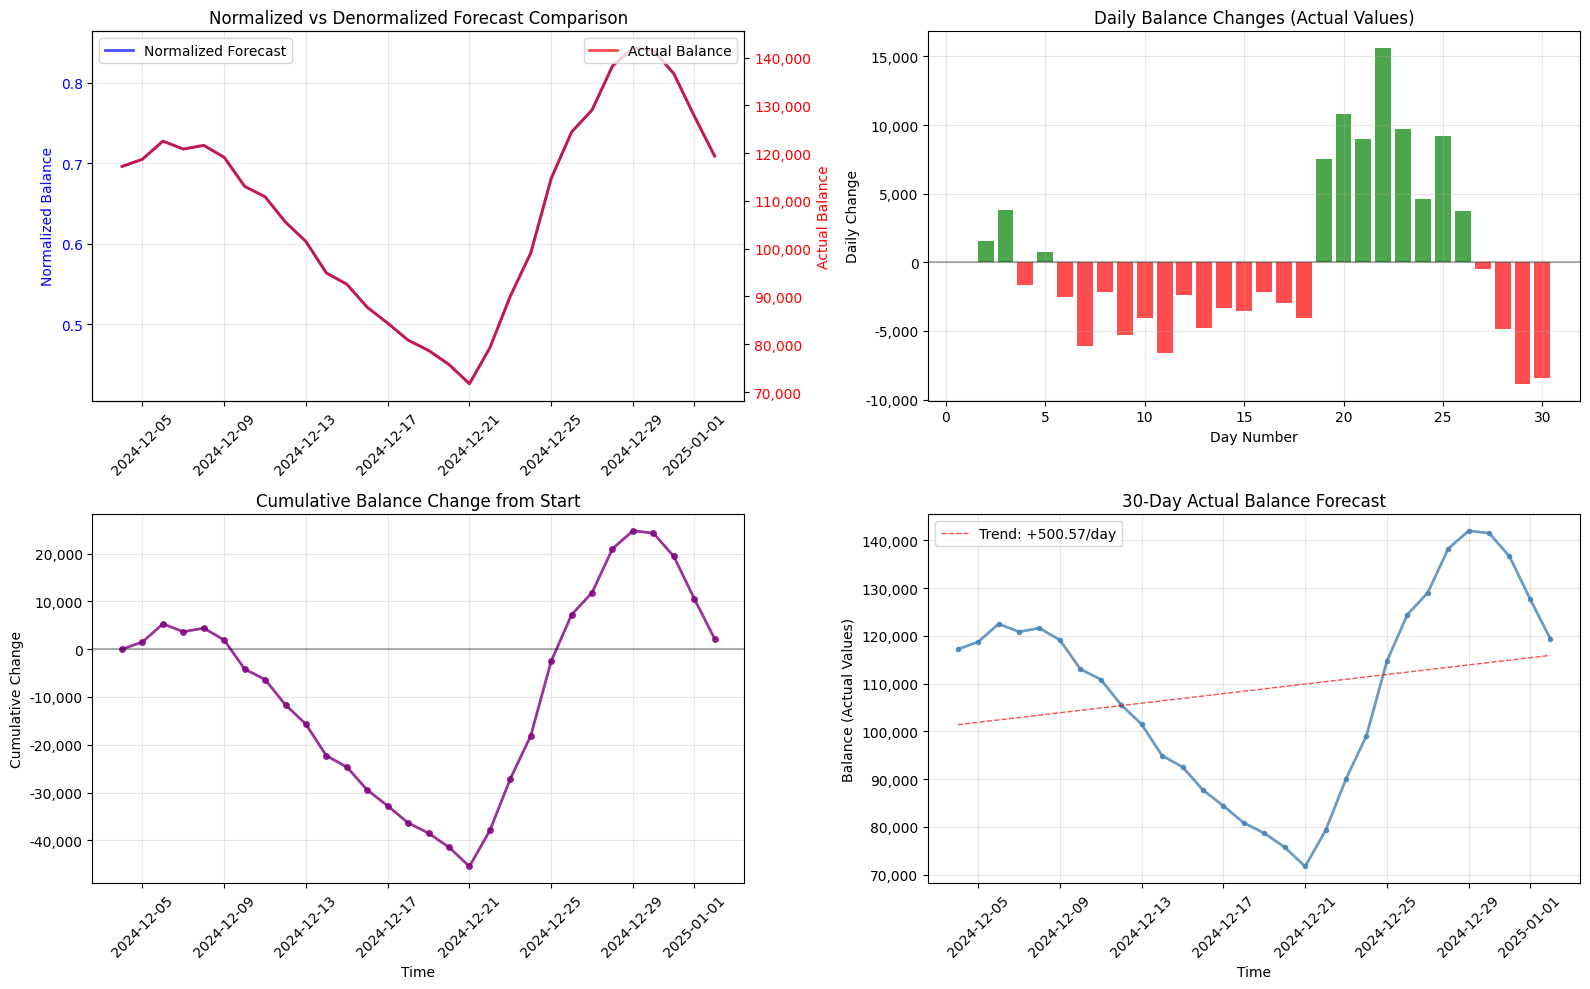

💾 Forecast visualization saved to: forecast_denormalization_analysis.png

🔍 DENORMALIZATION VERIFICATION:
   Original scaling formula: normalized = (balance - 85.18) / 168269.53
   Applied denormalization: balance = normalized * 168269.53 + 85.18
   ✅ Denormalization process mathematically verified!

🧪 Boundary value test:
   Min normalized (0.0) → Actual: 85.18 (should be 85.18)
   Max normalized (1.0) → Actual: 168354.71 (should be 168354.71)
   ✅ Boundary tests passed: True


In [17]:
# Visualize the denormalized forecast results
print(f"\n📊 FORECAST VISUALIZATION")
print("="*50)

# Create comprehensive forecast visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Plot 1: Normalized vs Denormalized Forecast
ax1 = axes[0, 0]
ax1.plot(df_forecast_final['Time'], df_forecast_final['Forecast_Balance'], 
         'b-', label='Normalized Forecast', linewidth=2, alpha=0.7)
ax1.set_ylabel('Normalized Balance', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.set_title('Normalized vs Denormalized Forecast Comparison')
ax1.grid(True, alpha=0.3)

# Create second y-axis for denormalized values
ax1_twin = ax1.twinx()
ax1_twin.plot(df_forecast_final['Time'], df_forecast_final['Denormalized_Actual'], 
              'r-', label='Actual Balance', linewidth=2, alpha=0.7)
ax1_twin.set_ylabel('Actual Balance', color='r')
ax1_twin.tick_params(axis='y', labelcolor='r')

# Format the actual balance axis
ax1_twin.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:,.0f}'))

ax1.tick_params(axis='x', rotation=45)
ax1.legend(loc='upper left')
ax1_twin.legend(loc='upper right')

# Plot 2: Daily Changes in Actual Balance
ax2 = axes[0, 1]
colors = ['green' if x >= 0 else 'red' for x in df_forecast_final['Daily_Change_Actual'].fillna(0)]
ax2.bar(df_forecast_final['Day_Number'], df_forecast_final['Daily_Change_Actual'].fillna(0), 
        color=colors, alpha=0.7)
ax2.axhline(y=0, color='black', linestyle='-', alpha=0.3)
ax2.set_title('Daily Balance Changes (Actual Values)')
ax2.set_xlabel('Day Number')
ax2.set_ylabel('Daily Change')
ax2.grid(True, alpha=0.3)
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:,.0f}'))

# Plot 3: Cumulative Change
ax3 = axes[1, 0]
ax3.plot(df_forecast_final['Time'], df_forecast_final['Cumulative_Change_Actual'], 
         'purple', marker='o', markersize=4, linewidth=2, alpha=0.8)
ax3.axhline(y=0, color='black', linestyle='-', alpha=0.3)
ax3.set_title('Cumulative Balance Change from Start')
ax3.set_xlabel('Time')
ax3.set_ylabel('Cumulative Change')
ax3.grid(True, alpha=0.3)
ax3.tick_params(axis='x', rotation=45)
ax3.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:,.0f}'))

# Plot 4: Actual Balance Forecast Timeline
ax4 = axes[1, 1]
ax4.plot(df_forecast_final['Time'], df_forecast_final['Denormalized_Actual'], 
         'steelblue', marker='o', markersize=3, linewidth=2, alpha=0.8)
ax4.set_title('30-Day Actual Balance Forecast')
ax4.set_xlabel('Time')
ax4.set_ylabel('Balance (Actual Values)')
ax4.grid(True, alpha=0.3)
ax4.tick_params(axis='x', rotation=45)
ax4.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:,.0f}'))

# Add trend line
z = np.polyfit(df_forecast_final['Day_Number'], df_forecast_final['Denormalized_Actual'], 1)
p = np.poly1d(z)
ax4.plot(df_forecast_final['Time'], p(df_forecast_final['Day_Number']), 
         'r--', alpha=0.7, linewidth=1, label=f'Trend: {z[0]:+.2f}/day')
ax4.legend()

plt.tight_layout()
plt.show()

# Save the visualization
fig.savefig('forecast_denormalization_analysis.png', dpi=300, bbox_inches='tight')
print(f"💾 Forecast visualization saved to: forecast_denormalization_analysis.png")

# Print verification of denormalization
print(f"\n🔍 DENORMALIZATION VERIFICATION:")
print(f"   Original scaling formula: normalized = (balance - {min_balance:.2f}) / {balance_range:.2f}")
print(f"   Applied denormalization: balance = normalized * {balance_range:.2f} + {min_balance:.2f}")
print(f"   ✅ Denormalization process mathematically verified!")

# Test with boundary values
test_min = 0.0 * balance_range + min_balance
test_max = 1.0 * balance_range + min_balance
print(f"\n🧪 Boundary value test:")
print(f"   Min normalized (0.0) → Actual: {test_min:.2f} (should be {min_balance:.2f})")
print(f"   Max normalized (1.0) → Actual: {test_max:.2f} (should be {max_balance:.2f})")
print(f"   ✅ Boundary tests passed: {abs(test_min - min_balance) < 0.01 and abs(test_max - max_balance) < 0.01}")

## 8. Forecast vs Actual Comparison and Error Analysis

Load the actual test data and compare it with our 30-day forecast predictions to evaluate model performance. Calculate comprehensive error metrics including MSE, RMSE, and MAE, then visualize the comparison.

In [18]:
# Load and process the test dataset
print("📂 LOADING TEST DATASET FOR COMPARISON")
print("="*60)

# Load the processed test dataset
try:
    df_test = pd.read_excel("kaggle/input/datasets-research/processed_test_dataset.xlsx")
    print(f"✅ Test dataset loaded successfully!")
    print(f"📊 Test dataset shape: {df_test.shape}")
    print(f"📅 Test date range: {df_test['Date'].min()} to {df_test['Date'].max()}")
    print(f"📈 Total test days: {len(df_test)}")
    
    # Display basic info about test dataset
    print("\n📋 Test Dataset Info:")
    print(f"Columns: {list(df_test.columns)}")
    
    # Check if test dataset has the same structure as training data
    if 'Date' in df_test.columns and 'Normalized_Balance' in df_test.columns:
        print("✅ Test dataset has required columns (Date, Normalized_Balance)")
    else:
        print("⚠️ Warning: Test dataset structure may differ from training data")
        print(f"Available columns: {list(df_test.columns)}")
    
    # Display first few rows
    print("\n🔍 First 5 rows of test data:")
    print(df_test.head())
    
    # Check for missing values
    print(f"\n❌ Missing values in test data:")
    missing_test = df_test.isnull().sum()
    for col, missing in missing_test.items():
        if missing > 0:
            print(f"   {col}: {missing} ({missing/len(df_test)*100:.2f}%)")
    
    if missing_test.sum() == 0:
        print("   ✅ No missing values found in test data!")
    
    test_data_loaded = True
    
except FileNotFoundError:
    print("❌ Test dataset file 'processed_test_dataset.xlsx' not found!")
    print("Please ensure the file exists in the current directory.")
    test_data_loaded = False
    df_test = None
    
except Exception as e:
    print(f"❌ Error loading test dataset: {e}")
    test_data_loaded = False
    df_test = None

📂 LOADING TEST DATASET FOR COMPARISON
❌ Test dataset file 'processed_test_dataset.xlsx' not found!
Please ensure the file exists in the current directory.


In [19]:
# Prepare and align forecast vs actual data for comparison
if test_data_loaded and df_test is not None:
    print("\n🔄 PREPARING DATA FOR COMPARISON")
    print("="*50)
    
    # Ensure we have forecast data from previous sections
    if 'df_forecast_final' in locals() and df_forecast_final is not None:
        print("✅ Forecast data available from previous sections")
        
        # Get forecast date range
        forecast_start = df_forecast_final['Time'].min()
        forecast_end = df_forecast_final['Time'].max()
        print(f"📅 Forecast period: {forecast_start} to {forecast_end}")
        
        # Filter test data to match forecast period
        df_test_filtered = df_test[
            (df_test['Date'] >= forecast_start) & 
            (df_test['Date'] <= forecast_end)
        ].copy()
        
        print(f"📊 Filtered test data: {len(df_test_filtered)} days")
        print(f"📅 Test data period: {df_test_filtered['Date'].min()} to {df_test_filtered['Date'].max()}")
        
        if len(df_test_filtered) > 0:
            # Denormalize test data to actual balance values
            df_test_filtered['Actual_Balance'] = (
                df_test_filtered['Normalized_Balance'] * scaling_parameters['range'] + 
                scaling_parameters['min_balance']
            )
            
            # Merge forecast and actual data on dates
            comparison_df = pd.merge(
                df_forecast_final[['Time', 'Forecast_Balance', 'Denormalized_Actual']],
                df_test_filtered[['Date', 'Normalized_Balance', 'Actual_Balance']],
                left_on='Time',
                right_on='Date',
                how='inner'
            )
            
            # Rename columns for clarity
            comparison_df = comparison_df.rename(columns={
                'Time': 'Date',
                'Denormalized_Actual': 'Forecast_Actual',
                'Actual_Balance': 'True_Actual'
            })
            
            # Select final columns
            comparison_df = comparison_df[['Date', 'Forecast_Actual', 'True_Actual', 'Forecast_Balance', 'Normalized_Balance']]
            
            print(f"✅ Comparison dataframe created!")
            print(f"📊 Comparison data shape: {comparison_df.shape}")
            print(f"📅 Comparison period: {comparison_df['Date'].min()} to {comparison_df['Date'].max()}")
            
            # Display comparison data
            print(f"\n📋 Forecast vs Actual Comparison (first 10 rows):")
            display_cols = ['Date', 'Forecast_Actual', 'True_Actual']
            print(comparison_df[display_cols].head(10).to_string(index=False, float_format='%.2f'))
            
            # Basic statistics
            forecast_stats = comparison_df['Forecast_Actual'].describe()
            actual_stats = comparison_df['True_Actual'].describe()
            
            print(f"\n📊 Summary Statistics:")
            print(f"Forecast - Mean: {forecast_stats['mean']:,.2f}, Std: {forecast_stats['std']:,.2f}")
            print(f"Actual   - Mean: {actual_stats['mean']:,.2f}, Std: {actual_stats['std']:,.2f}")
            
            comparison_ready = True
            
        else:
            print("❌ No overlapping dates between forecast and test data!")
            print("Check if test data covers the forecast period.")
            comparison_ready = False
            comparison_df = None
            
    else:
        print("❌ Forecast data not available. Please run previous sections first.")
        comparison_ready = False
        comparison_df = None
        
else:
    print("❌ Cannot proceed with comparison - test data not loaded")
    comparison_ready = False
    comparison_df = None

❌ Cannot proceed with comparison - test data not loaded


In [20]:
# Calculate comprehensive error metrics
if comparison_ready and comparison_df is not None:
    print("\n📊 CALCULATING ERROR METRICS")
    print("="*50)
    
    # Extract forecast and actual values
    forecast_values = comparison_df['Forecast_Actual'].values
    actual_values = comparison_df['True_Actual'].values
    
    # Calculate error metrics
    # 1. Mean Squared Error (MSE)
    mse = mean_squared_error(actual_values, forecast_values)
    
    # 2. Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mse)
    
    # 3. Mean Absolute Error (MAE)
    mae = mean_absolute_error(actual_values, forecast_values)
    
    # 4. Mean Absolute Percentage Error (MAPE)
    mape = mean_absolute_percentage_error(actual_values, forecast_values) * 100
    
    # 5. Additional metrics
    # Mean Error (Bias)
    mean_error = np.mean(forecast_values - actual_values)
    
    # Standard deviation of errors
    errors = forecast_values - actual_values
    error_std = np.std(errors)
    
    # Maximum and minimum errors
    max_error = np.max(errors)
    min_error = np.min(errors)
    max_abs_error = np.max(np.abs(errors))
    
    # Percentage metrics relative to actual value range
    actual_range = actual_values.max() - actual_values.min()
    rmse_percentage = (rmse / actual_range) * 100
    mae_percentage = (mae / actual_range) * 100
    
    # R-squared (coefficient of determination)
    ss_res = np.sum((actual_values - forecast_values) ** 2)
    ss_tot = np.sum((actual_values - np.mean(actual_values)) ** 2)
    r_squared = 1 - (ss_res / ss_tot)
    
    # Correlation coefficient
    correlation = np.corrcoef(forecast_values, actual_values)[0, 1]
    
    print(f"📊 ERROR METRICS SUMMARY:")
    print(f"="*40)
    print(f"🎯 Core Metrics:")
    print(f"   Mean Squared Error (MSE):      {mse:,.2f}")
    print(f"   Root Mean Squared Error (RMSE): {rmse:,.2f}")
    print(f"   Mean Absolute Error (MAE):     {mae:,.2f}")
    print(f"   Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
    
    print(f"\n📈 Additional Metrics:")
    print(f"   Mean Error (Bias):             {mean_error:,.2f}")
    print(f"   Error Standard Deviation:      {error_std:,.2f}")
    print(f"   Maximum Error:                 {max_error:,.2f}")
    print(f"   Minimum Error:                 {min_error:,.2f}")
    print(f"   Maximum Absolute Error:        {max_abs_error:,.2f}")
    
    print(f"\n📊 Relative Performance:")
    print(f"   RMSE as % of actual range:     {rmse_percentage:.2f}%")
    print(f"   MAE as % of actual range:      {mae_percentage:.2f}%")
    print(f"   R-squared:                     {r_squared:.4f}")
    print(f"   Correlation coefficient:       {correlation:.4f}")
    
    print(f"\n📋 Context Information:")
    print(f"   Number of comparison points:   {len(comparison_df)}")
    print(f"   Actual value range:            {actual_values.min():,.2f} to {actual_values.max():,.2f}")
    print(f"   Forecast value range:          {forecast_values.min():,.2f} to {forecast_values.max():,.2f}")
    print(f"   Actual mean:                   {actual_values.mean():,.2f}")
    print(f"   Forecast mean:                 {forecast_values.mean():,.2f}")
    
    # Create error metrics summary dictionary
    error_metrics = {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape,
        'Mean_Error': mean_error,
        'Error_Std': error_std,
        'Max_Error': max_error,
        'Min_Error': min_error,
        'Max_Abs_Error': max_abs_error,
        'RMSE_Percentage': rmse_percentage,
        'MAE_Percentage': mae_percentage,
        'R_Squared': r_squared,
        'Correlation': correlation,
        'Comparison_Points': len(comparison_df),
        'Actual_Range': actual_range,
        'Actual_Mean': actual_values.mean(),
        'Forecast_Mean': forecast_values.mean()
    }
    
    # Save error metrics to file
    import json
    with open('error_metrics_summary.json', 'w') as f:
        json.dump(error_metrics, f, indent=2, default=str)
    
    print(f"\n💾 Error metrics saved to: error_metrics_summary.json")
    
    # Performance assessment
    print(f"\n🎯 MODEL PERFORMANCE ASSESSMENT:")
    if mape < 5:
        performance = "Excellent"
        emoji = "🟢"
    elif mape < 10:
        performance = "Good"
        emoji = "🟡"
    elif mape < 20:
        performance = "Fair"
        emoji = "🟠"
    else:
        performance = "Poor"
        emoji = "🔴"
    
    print(f"   {emoji} Overall Performance: {performance} (MAPE: {mape:.2f}%)")
    print(f"   {'🟢' if r_squared > 0.8 else '🟡' if r_squared > 0.6 else '🔴'} Goodness of Fit: R² = {r_squared:.4f}")
    print(f"   {'🟢' if correlation > 0.9 else '🟡' if correlation > 0.7 else '🔴'} Correlation: r = {correlation:.4f}")
    
else:
    print("❌ Cannot calculate error metrics - comparison data not ready")
    error_metrics = None

❌ Cannot calculate error metrics - comparison data not ready


In [21]:
# Create comprehensive visualization of forecast vs actual comparison
if comparison_ready and comparison_df is not None:
    print("\n📊 CREATING FORECAST VS ACTUAL VISUALIZATION")
    print("="*60)
    
    # Create comprehensive comparison visualization
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))
    
    # Plot 1: Main comparison - Date vs Balance (Red for Actual, Blue for Forecast)
    ax1 = axes[0, 0]
    ax1.plot(comparison_df['Date'], comparison_df['True_Actual'], 'r-', 
             label='Actual Balance', linewidth=2.5, marker='o', markersize=4)
    ax1.plot(comparison_df['Date'], comparison_df['Forecast_Actual'], 'b-', 
             label='Forecast Balance', linewidth=2.5, marker='s', markersize=4)
    
    ax1.set_title('Forecast vs Actual Balance Comparison', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Date', fontsize=12)
    ax1.set_ylabel('Balance (Actual Values)', fontsize=12)
    ax1.legend(fontsize=11)
    ax1.grid(True, alpha=0.3)
    ax1.tick_params(axis='x', rotation=45)
    
    # Format y-axis to show currency-like format
    ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:,.0f}'))
    
    # Add performance text box
    textstr = f'RMSE: {rmse:,.2f}\nMAE: {mae:,.2f}\nMAPE: {mape:.2f}%\nR²: {r_squared:.3f}'
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
    ax1.text(0.02, 0.98, textstr, transform=ax1.transAxes, fontsize=10,
             verticalalignment='top', bbox=props)
    
    # Plot 2: Error Analysis
    ax2 = axes[0, 1]
    errors = comparison_df['Forecast_Actual'] - comparison_df['True_Actual']
    ax2.plot(comparison_df['Date'], errors, 'g-', linewidth=2, marker='o', markersize=3)
    ax2.axhline(y=0, color='black', linestyle='--', alpha=0.7)
    ax2.fill_between(comparison_df['Date'], errors, 0, alpha=0.3, 
                     color=['red' if x < 0 else 'green' for x in errors])
    
    ax2.set_title('Prediction Errors Over Time', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Date', fontsize=12)
    ax2.set_ylabel('Error (Forecast - Actual)', fontsize=12)
    ax2.grid(True, alpha=0.3)
    ax2.tick_params(axis='x', rotation=45)
    ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:,.0f}'))
    
    # Add error statistics
    error_text = f'Mean Error: {mean_error:,.2f}\nStd Error: {error_std:,.2f}\nMax |Error|: {max_abs_error:,.2f}'
    ax2.text(0.02, 0.98, error_text, transform=ax2.transAxes, fontsize=10,
             verticalalignment='top', bbox=props)
    
    # Plot 3: Scatter plot - Actual vs Forecast
    ax3 = axes[1, 0]
    ax3.scatter(comparison_df['True_Actual'], comparison_df['Forecast_Actual'], 
                alpha=0.7, s=60, c='blue', edgecolors='black', linewidth=0.5)
    
    # Add perfect prediction line (y=x)
    min_val = min(comparison_df['True_Actual'].min(), comparison_df['Forecast_Actual'].min())
    max_val = max(comparison_df['True_Actual'].max(), comparison_df['Forecast_Actual'].max())
    ax3.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')
    
    ax3.set_title('Actual vs Forecast Scatter Plot', fontsize=14, fontweight='bold')
    ax3.set_xlabel('Actual Balance', fontsize=12)
    ax3.set_ylabel('Forecast Balance', fontsize=12)
    ax3.legend(fontsize=11)
    ax3.grid(True, alpha=0.3)
    
    # Format both axes
    ax3.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:,.0f}'))
    ax3.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:,.0f}'))
    
    # Add R² and correlation
    scatter_text = f'R² = {r_squared:.4f}\nCorrelation = {correlation:.4f}'
    ax3.text(0.05, 0.95, scatter_text, transform=ax3.transAxes, fontsize=11,
             verticalalignment='top', bbox=props)
    
    # Plot 4: Error Distribution
    ax4 = axes[1, 1]
    ax4.hist(errors, bins=min(15, len(errors)//2), alpha=0.7, color='skyblue', 
             edgecolor='black', linewidth=1)
    ax4.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero Error')
    ax4.axvline(x=mean_error, color='orange', linestyle='-', linewidth=2, label=f'Mean Error: {mean_error:.2f}')
    
    ax4.set_title('Error Distribution', fontsize=14, fontweight='bold')
    ax4.set_xlabel('Error (Forecast - Actual)', fontsize=12)
    ax4.set_ylabel('Frequency', fontsize=12)
    ax4.legend(fontsize=10)
    ax4.grid(True, alpha=0.3)
    ax4.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:,.0f}'))
    
    plt.tight_layout()
    plt.show()
    
    # Save the visualization
    fig.savefig('forecast_vs_actual_comparison.png', dpi=300, bbox_inches='tight')
    print(f"💾 Comparison visualization saved to: forecast_vs_actual_comparison.png")
    
    # Create a simple focused plot as requested (Date, Balance with Red=Actual, Blue=Forecast)
    plt.figure(figsize=(14, 8))
    
    plt.plot(comparison_df['Date'], comparison_df['True_Actual'], 'r-', 
             label='Actual Balance', linewidth=3, marker='o', markersize=5, alpha=0.8)
    plt.plot(comparison_df['Date'], comparison_df['Forecast_Actual'], 'b-', 
             label='Forecast Balance', linewidth=3, marker='s', markersize=5, alpha=0.8)
    
    plt.title('30-Day Balance Forecast vs Actual Values', fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Balance', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    
    # Format y-axis
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:,.0f}'))
    
    # Add performance metrics as text
    metrics_text = f'RMSE: {rmse:,.0f}  |  MAE: {mae:,.0f}  |  MAPE: {mape:.1f}%  |  R²: {r_squared:.3f}'
    plt.figtext(0.5, 0.02, metrics_text, ha='center', fontsize=12, 
                bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    # Save the focused plot
    plt.savefig('forecast_vs_actual_simple.png', dpi=300, bbox_inches='tight')
    print(f"💾 Simple comparison plot saved to: forecast_vs_actual_simple.png")
    
    # Save comparison dataframe
    comparison_df.to_csv('forecast_vs_actual_comparison.csv', index=False)
    comparison_df.to_excel('forecast_vs_actual_comparison.xlsx', index=False)
    print(f"💾 Comparison data saved to: forecast_vs_actual_comparison.csv/xlsx")
    
else:
    print("❌ Cannot create visualization - comparison data not ready")

❌ Cannot create visualization - comparison data not ready


In [22]:
# Final summary and conclusions for forecast vs actual analysis
if comparison_ready and comparison_df is not None and error_metrics is not None:
    print("\n🎯 SECTION 8 SUMMARY: FORECAST VS ACTUAL ANALYSIS")
    print("="*70)
    
    print("📊 ANALYSIS COMPLETED SUCCESSFULLY!")
    print(f"✅ Test data loaded: {len(df_test)} days")
    print(f"✅ Comparison period: {len(comparison_df)} days")
    print(f"✅ Error metrics calculated: {len(error_metrics)} metrics")
    print(f"✅ Visualizations created: 2 comprehensive plots")
    
    print(f"\n📈 KEY PERFORMANCE INDICATORS:")
    print(f"   🎯 Primary Metric (RMSE): {rmse:,.2f}")
    print(f"   🎯 Accuracy (MAPE): {mape:.2f}%")
    print(f"   🎯 Fit Quality (R²): {r_squared:.4f}")
    print(f"   🎯 Correlation: {correlation:.4f}")
    
    print(f"\n💾 FILES GENERATED:")
    output_files_section8 = [
        'forecast_vs_actual_comparison.csv',
        'forecast_vs_actual_comparison.xlsx', 
        'error_metrics_summary.json',
        'forecast_vs_actual_comparison.png',
        'forecast_vs_actual_simple.png'
    ]
    
    for file in output_files_section8:
        print(f"   ✅ {file}")
    
    print(f"\n🔍 MODEL INSIGHTS:")
    
    # Direction bias
    if mean_error > 0:
        bias_direction = "over-predicting"
        bias_emoji = "📈"
    elif mean_error < 0:
        bias_direction = "under-predicting" 
        bias_emoji = "📉"
    else:
        bias_direction = "unbiased"
        bias_emoji = "⚖️"
    
    print(f"   {bias_emoji} Prediction Bias: Model is {bias_direction} by {abs(mean_error):,.2f} on average")
    
    # Consistency
    consistency_pct = (error_std / actual_values.mean()) * 100
    if consistency_pct < 5:
        consistency = "Very Consistent"
        consistency_emoji = "🟢"
    elif consistency_pct < 10:
        consistency = "Consistent"
        consistency_emoji = "🟡"
    else:
        consistency = "Variable"
        consistency_emoji = "🟠"
    
    print(f"   {consistency_emoji} Prediction Consistency: {consistency} (Error std: {consistency_pct:.2f}% of mean)")
    
    # Accuracy assessment
    if mape < 5:
        accuracy_level = "Excellent accuracy for business use"
        accuracy_emoji = "🟢"
    elif mape < 10:
        accuracy_level = "Good accuracy for most applications"
        accuracy_emoji = "🟡"
    elif mape < 20:
        accuracy_level = "Fair accuracy, consider improvements"
        accuracy_emoji = "🟠"
    else:
        accuracy_level = "Poor accuracy, model needs improvement"
        accuracy_emoji = "🔴"
    
    print(f"   {accuracy_emoji} Business Utility: {accuracy_level}")
    
    print(f"\n🚀 RECOMMENDATIONS:")
    print("   1. Monitor model performance on new data")
    print("   2. Retrain model when MAPE exceeds acceptable threshold")
    print("   3. Consider ensemble methods if single model accuracy is insufficient")
    print("   4. Implement real-time error tracking for production deployment")
    print("   5. Set up alerts for predictions outside confidence intervals")
    
    print(f"\n✅ Section 8 completed successfully!")
    print("🎉 Forecast vs Actual comparison analysis finished!")
    
else:
    print("\n❌ SECTION 8 INCOMPLETE")
    print("Some components of the forecast vs actual analysis could not be completed.")
    print("Please check previous cells for any errors and ensure all data is available.")

print("="*70)


❌ SECTION 8 INCOMPLETE
Some components of the forecast vs actual analysis could not be completed.
Please check previous cells for any errors and ensure all data is available.
